# 基于大学生的身高，体重，性别等数据的体测成绩的分析与评分标准的意见

前言 当今部分大学生最担心的不是专业课成绩与绩点，反倒是体测成绩的影响。体测关乎毕业与奖学金。但是不像专业课，每一位大学生都有着相近的基础;每一位学生的天赋和基础身体条件，甚至于性别对体测有天差地别的影响。笔者认为评分标准应该在考虑到每一位学生的身体基础的条件上对成绩进行一定的修正，本次分析就是对此方面的探讨。

数据集基于2022年春季河海大学2018级本科生(即大四)体测数据，将其转存为utf-8格式的csv文件导入

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

file = open(r"E:\111\导论仓库\term_final\2022年河海大学2018级本科生体测数据.csv",'r',encoding='utf-8')
dl = pd.read_csv(file)
file.close()

In [2]:
print(dl.shape)

(3761, 16)


一共3761条数据

In [3]:
dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3761 entries, 0 to 3760
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   学号       3761 non-null   object 
 1   姓名       3761 non-null   object 
 2   性别       3761 non-null   object 
 3   学院号      3761 non-null   object 
 4   专业号      3761 non-null   int64  
 5   班级号      3761 non-null   object 
 6   身高       3616 non-null   object 
 7   体重       3573 non-null   float64
 8   肺活量      3575 non-null   object 
 9   50米跑     3572 non-null   object 
 10  立定跳远     3570 non-null   float64
 11  坐位体前屈    3570 non-null   float64
 12  800米跑    1446 non-null   object 
 13  1000米跑   2123 non-null   object 
 14  一分钟仰卧起坐  1449 non-null   float64
 15  引体向上     2124 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 470.2+ KB


我们获得了毛数据之后，对得到的数据进行预处理。在对姓名学号进行脱敏处理前，先来检验一下是否重复录入成绩，有的话删除。

In [4]:
dl = dl.drop_duplicates(subset = ['学号'])#认为学号相同的就算重复数据，删去
print(dl.shape)

(3761, 16)


很好，我们得到的数据没有重复的，接下来先对数据进行脱敏处理,同时方便处理，男为1，女为2
。同时男生的仰卧起坐800米，女生的引体向上1000米置0<br>
为什么不空着这些数据不管呢？ 因为我发现原始数据集中有一点点的瑕疵，极个别的女生的引体向上被填入了仰卧起坐的数据。为了排除其他类似的问题，直接填入0

In [5]:
dl = dl.drop(columns = ['学号','学院号','专业号','姓名','班级号'])#这些涉及到所有学生的个人信息，删去
dl.loc[dl["性别"] == "女",'性别'] = 2
dl.loc[dl["性别"] == "男",'性别'] = 1
dl.loc[dl["性别"] == 2,"1000米跑"]="0'00"
dl.loc[dl["性别"] == 2,"引体向上"]=0.0
dl.loc[dl["性别"] == 1,"一分钟仰卧起坐"]=0.0
dl.loc[dl["性别"] == 1,"800米跑"]="0'00"

对于不敏感的数据，我们还要对当前的数据进行清洗：<br>根据标题，我们要去除没有性别，体重，身高数据的数据行。（性别是从学校数据库里获得的 因此不考虑）<br>同时还要刨去免测人员。

In [6]:
dl = dl.dropna(subset = ['身高','体重'])
dl = dl[dl['身高'].str.contains("免测") == False]
dl = dl[dl['肺活量'].str.contains("免测") == False]
dl = dl[dl['50米跑'].str.contains("免测") == False]
print(dl.shape)

(3568, 11)


先保存去除无效的文件，因为在观察体重对各个环节的影响时填充数据会导致回归时即进行最小二乘法的时候产生较大的误差

In [7]:
dl.to_csv(r"E:\111\导论仓库\term_final\清洗后数据.csv",index=0,encoding='utf_8_sig')

剩下了3568行有效数据，接下来还要填补空缺，利用了中位数。（男女生分开填充）<br><br>


In [8]:
dl["肺活量"] = dl.groupby("性别")["肺活量"].fillna(value=dl["肺活量"].median())
dl["50米跑"] = dl.groupby("性别")["50米跑"].fillna(value=dl["50米跑"].median())
dl["立定跳远"] = dl.groupby("性别")["立定跳远"].fillna(value=dl["立定跳远"].median())
dl["坐位体前屈"] = dl.groupby("性别")["坐位体前屈"].fillna(value=dl["坐位体前屈"].median())
dl["800米跑"] = dl.groupby("性别")["800米跑"].fillna(method='ffill')
dl["1000米跑"] = dl.groupby("性别")["1000米跑"].fillna(method='ffill')
dl["一分钟仰卧起坐"] = dl.groupby("性别")["一分钟仰卧起坐"].fillna(value=dl["一分钟仰卧起坐"].median())
dl["引体向上"] = dl.groupby("性别")["引体向上"].fillna(value=dl["引体向上"].median())

由于长跑数据格式特殊，故利用np.array处理长跑数据，单位按秒记录，再重新填入dataframe。

In [9]:
otm = np.array(dl.loc[:,"1000米跑"])
em = np.array(dl.loc[:,"800米跑"])
otm_second = []
em_second = []

for i in range (len(otm)):
    temp = 60*int(otm[i][0]) + 10*int(otm[i][2]) + int(otm[i][3])
    otm_second.append(temp)
for j in range (len(em)):
    temp = 60*int(em[j][0]) + 10*int(em[j][2]) + int(em[j][3])
    em_second.append(temp)

dl["1000米跑"] = dl["1000米跑"].replace(otm,otm_second)
dl["800米跑"] = dl["800米跑"].replace(em,em_second)

小小的保存一下数据清洗完的结果

In [10]:
dl.to_csv(r"E:\111\导论仓库\term_final\清洗后数据3.csv",index=0,encoding='utf_8_sig')

接下来为了精确的分析各项之间的差异，分组拆分男女生,分析其中有无不合理数据

In [11]:
groups = dl.groupby(dl.性别)
boy_dl = groups.get_group(1)
girl_dl = groups.get_group(2)
boy_dl = boy_dl.apply(lambda x:x.astype(float))
girl_dl = girl_dl.apply(lambda x:x.astype(float))

In [47]:
boy_dllabels = boy_dl.columns.values.tolist()
girl_dllabels = girl_dl.columns.values.tolist()
for i in range (11):
    print(boy_dllabels[i]+":")
    print(boy_dl.iloc[:,i].max())
    print(boy_dl.iloc[:,i].min())
    print("\n")
    
print("下面是女生的")
for i in range (11):
    print(girl_dllabels[i]+":")
    print(girl_dl.iloc[:,i].max())
    print(girl_dl.iloc[:,i].min())
    print("\n")

print(boy_dl.shape[0]+girl_dl.shape[0])

性别:
1.0
1.0


身高:
197.0
155.0


体重:
135.0
43.6


肺活量:
8884.0
1070.0


50米跑:
10.8
5.9


立定跳远:
310.0
140.0


坐位体前屈:
40.0
-16.9


800米跑:
0.0
0.0


1000米跑:
390.0
180.0


一分钟仰卧起坐:
0.0
0.0


引体向上:
61.0
0.0


下面是女生的
性别:
2.0
2.0


身高:
180.7
144.3


体重:
108.0
35.3


肺活量:
6427.0
1200.0


50米跑:
13.7
7.0


立定跳远:
280.0
120.0


坐位体前屈:
33.4
-10.8


800米跑:
353.0
178.0


1000米跑:
0.0
0.0


一分钟仰卧起坐:
70.0
20.0


引体向上:
0.0
0.0


3568


数据基本上符合预期分布。 虽然肺活量的数据有点超出我的想象，但是还是处于正常区间。

In [13]:
boy_dl.to_csv(r"E:\111\导论仓库\term_final\清洗后男生数据.csv",index=0,encoding='utf_8_sig')
girl_dl.to_csv(r"E:\111\导论仓库\term_final\清洗后女生数据.csv",index=0,encoding='utf_8_sig')

#### 至此我们清洗数据的工作已经结束了，接下来就是数据的分析

在性别方面，体测最大的出入就是在两个男女不同的项目--引体向上和仰卧起坐了。仰卧起坐是对核心力量的检测，而引体向上却是对背部及上肢力量的反应。这两种迥然不同的项目，对男女生成绩的评定是否公平合理呢？

故首先从性别上分析，男生的引体向上和女生的仰卧起坐的得分情况是否接近。

In [14]:
yingti = np.float32(boy_dl.loc[:,"引体向上"])
yangwo = np.float32(girl_dl.loc[:,"一分钟仰卧起坐"])
zero_b=0
zero_g=0
#作为一名体育不太好的同学，我总是在引体向上这方面拿到0分，下面是零分率的计算
for i in range (len(yingti)):
    if yingti[i]< 6:
        zero_b += 1
zerorate_b = zero_b/len(yingti)
for j in range (len(yangwo)):
    if yangwo[j] < 17:
        zero_g += 1
zerorate_g = zero_g/len(yangwo)
print(zerorate_b,zerorate_g)

0.22232689590202542 0.0


这代表着女生 <strong>完全没有零分的同学！</strong> <br>
而男生却有 <strong>22%的同学一分没有！</strong> <br>
单单从此点就可以看出，引体向上这个项目的评分标准是 <strong>完全不合理的!</strong><br>
我们再来看看这两个项目的均分，方差，中位数以及分数分布

In [15]:
#下面两栏是分数转换，很冗长....
score_yingti = []
score_yangwo = []
for i in range (len(yingti)):
    if yingti[i] < 6:
        score_yingti.append(0)
        continue
    
    elif yingti[i]<=11 and yingti[i]>=6:
        score_yingti.append((yingti[i]-5)*10)
        continue

    elif yingti[i]>=12 and yingti[i]<=16:
        score_yingti.append(60+(yingti[i]-11)*4)
        continue

    elif yingti[i]>=17 and yingti[i]<=19:
        score_yingti.append(80+(yingti[i]-16)*5)
        continue
    
    elif yingti[i]>=20:
        score_yingti.append(100)
        continue

In [16]:
for j in range (len(yangwo)):
    if (yangwo[j]-1)/2 < 8:
        score_yangwo.append(0)
        continue
    
    elif (yangwo[j]-1)/2 >= 8 and (yangwo[j]-1)/2 <= 13.5:
        score_yangwo.append( float(( int((yangwo[j]-1)/2) - 7 )* 10 ))
        continue
    
    elif (yangwo[j]-1)/2 >= 14 and (yangwo[j]-1)/2 <= 22.5:
        score_yangwo.append( float(( int((yangwo[j]-1)/2) - 13) * 2 + 60))
        continue
    
    elif yangwo[j] <50 and yangwo[j] >= 47:
        score_yangwo.append(80.0)
    
    elif yangwo[j] >= 50 and yangwo[j] < 53:
        score_yangwo.append(85.0)
        continue
        
    elif yangwo[j] >= 53 and yangwo[j] < 55:
        score_yangwo.append(90.0)
        continue
        
    elif yangwo[j] >= 55 and yangwo[j] < 57:
        score_yangwo.append(95.0)
        continue
        
    elif yangwo[j] >= 57 :
        score_yangwo.append(100.0)
        continue

In [17]:
total_yingti = 0
total_yangwo = 0

for i in range (len(score_yingti)):
    total_yingti += score_yingti[i]
avg_yingti = total_yingti/len(score_yingti)

for i in range (len(score_yangwo)):
    total_yangwo += score_yangwo[i]
avg_yangwo = total_yangwo/len(score_yangwo)

print('%.2f' % avg_yingti,end=" ")
print('%.2f' % avg_yangwo,end=" ")
print('%.2f' % (avg_yangwo-avg_yingti),end="\n")

def get_median(data):
    data = sorted(data)
    size = len(data)
    if size % 2 == 0:
        median = (data[size//2] + data[size//2 - 1])/2
    if size % 2 == 1:
        median = data[(size-1)//2]
    return median

med_yingti = get_median(score_yingti)
med_yangwo = get_median(score_yangwo)

print(med_yingti,med_yangwo,med_yangwo-med_yingti)

var_yingti = np.var(score_yingti)
var_yangwo = np.var(score_yangwo)

print(var_yingti,end=" ")
print(var_yangwo,end="\n")

47.38 79.21 31.83
60.0 78.0 18.0
1057.9863194508077 88.86998670992924


男女生之间的体测成绩成绩已然被仰卧起坐，引体向上这两门拉开。从平均分的角度来看，男女之间的差距就有三十多分，换算到体测的总成绩（这两门都占10%）就是相差3分。我认为在一个项目的差距上能够有30多分是完全不正常的！况且引体向上的方差相较于仰卧起坐竟有十几倍大的差距，若仅仅从数据稳定性的角度看来，引体向上和仰卧起坐也是完全不能相比较的。从平均数，零分率，方差，中位数多方面看来，引体向上相比于仰卧起坐来说，是相对不合理不科学的。

下面是分数分布的可视化，我们看看这两门的分布状况

In [18]:
yingti_dis=np.zeros(11)

for i in range (len(score_yingti)):
    temp = int(score_yingti[i]/10)
    yingti_dis[temp]+=1

In [19]:
yangwo_dis=np.zeros(11)

for i in range (len(score_yangwo)):
    temp = int(score_yangwo[i]/10)
    yangwo_dis[temp]+=1
    

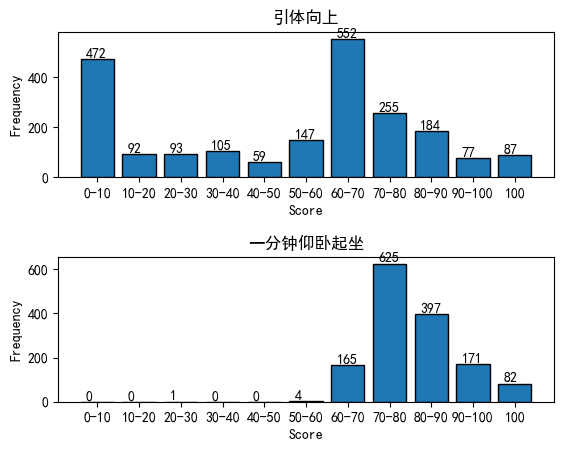

In [20]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.subplot(211)
x1 = [1,2,3,4,5,6,7,8,9,10,11]
y1 = yingti_dis

for i in range (11):
    plt.text(x=i+0.73,y=yingti_dis[i]+5.3,s="%d" % yingti_dis[i],rotation=0)
xlabels=["",'0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100']
plt.title("引体向上")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.xticks(range(12),xlabels)
plt.bar(x1,y1,alpha=1,width=0.8,edgecolor='black')

plt.subplot(212)
x2 = [1,2,3,4,5,6,7,8,9,10,11]
y2 = yangwo_dis
for i in range (11):
    plt.text(x=i+0.73,y=yangwo_dis[i]+6.3,s="%d" % yangwo_dis[i],rotation=0)
xlabels=["",'0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100']
plt.title("一分钟仰卧起坐")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.xticks(range(12),xlabels)
plt.bar(x2,y2,alpha=1,width=0.8,edgecolor='black')
plt.subplots_adjust(hspace=0.55)

plt.show()

  通过柱状图更能看出这两个项目之间的差距了，从最低得分方面看，我发现了仰卧起坐是个基本上可以让人及格的项目，对于部分拿0分的男生是**很不公平**的！即同样的0.22分位数，男生就是0分而女生却有机会拿到70分甚至更多。只是因为性别不同而失去总评的6到7分是十分不科学的，这样的评分或有机会导致性别对立或者歧视的加重。<br>
    
   从优秀率(90+)看，男生也不及女生。这同样是不合理的因素之一。<br>
   
   从整体图像的分布看，引体向上的成绩更像是两组两点分布加上几个组均匀分布的结果。而仰卧起坐更倾向于左偏的正态分布。然而基于对成绩分布的科学认知，后面这一组的成绩更符合测验的具体要求，反之引体向上的成绩是很不符合测试要求的。综合柱状图和零分率，平均数，中位数以及方差的分析，我认为引体向上这个项目应该**被替换掉，或者说更改评分标准！**

接下来我们看看体重与各个项目之间的相关性--采用相关系数的热力图

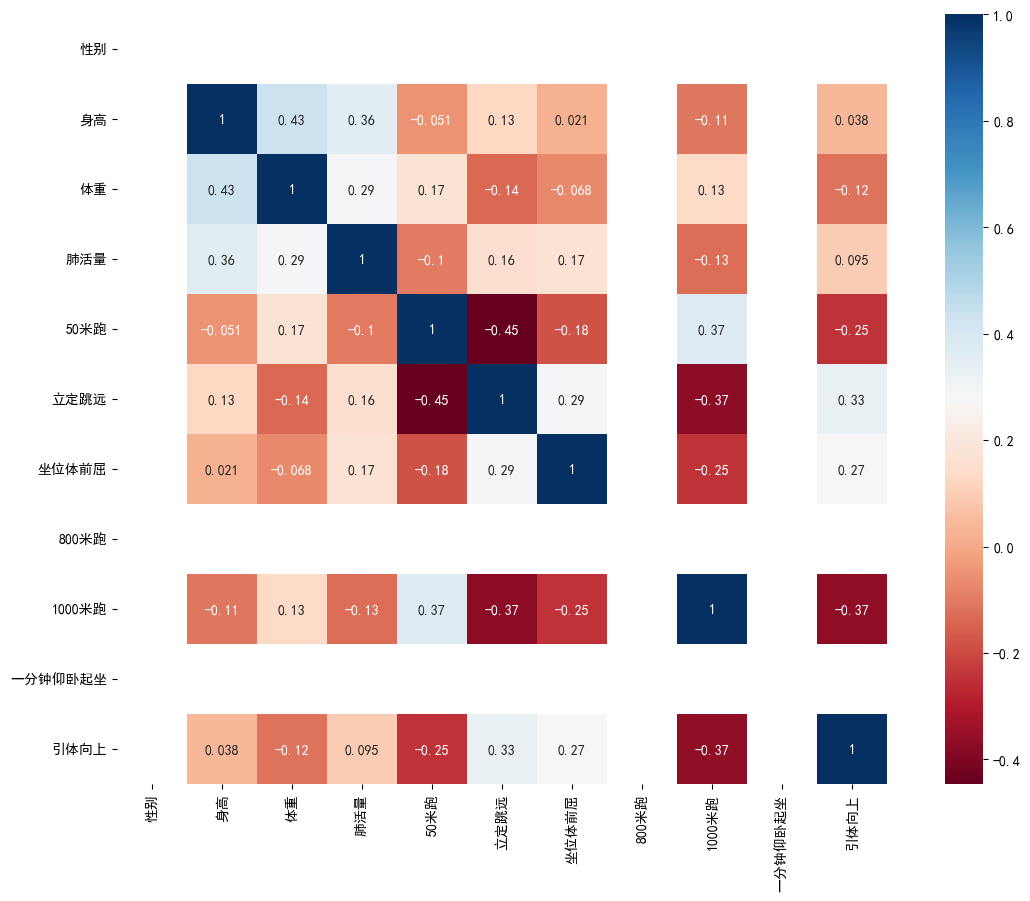

In [21]:
boy_dlcorr=boy_dl.corr()
plt.subplots(figsize=(15,10))
boy_dllabels = boy_dl.columns.values.tolist()
sns.heatmap(boy_dlcorr, annot = True, square = True, yticklabels = boy_dllabels , xticklabels = boy_dllabels , cmap='RdBu')
plt.show()

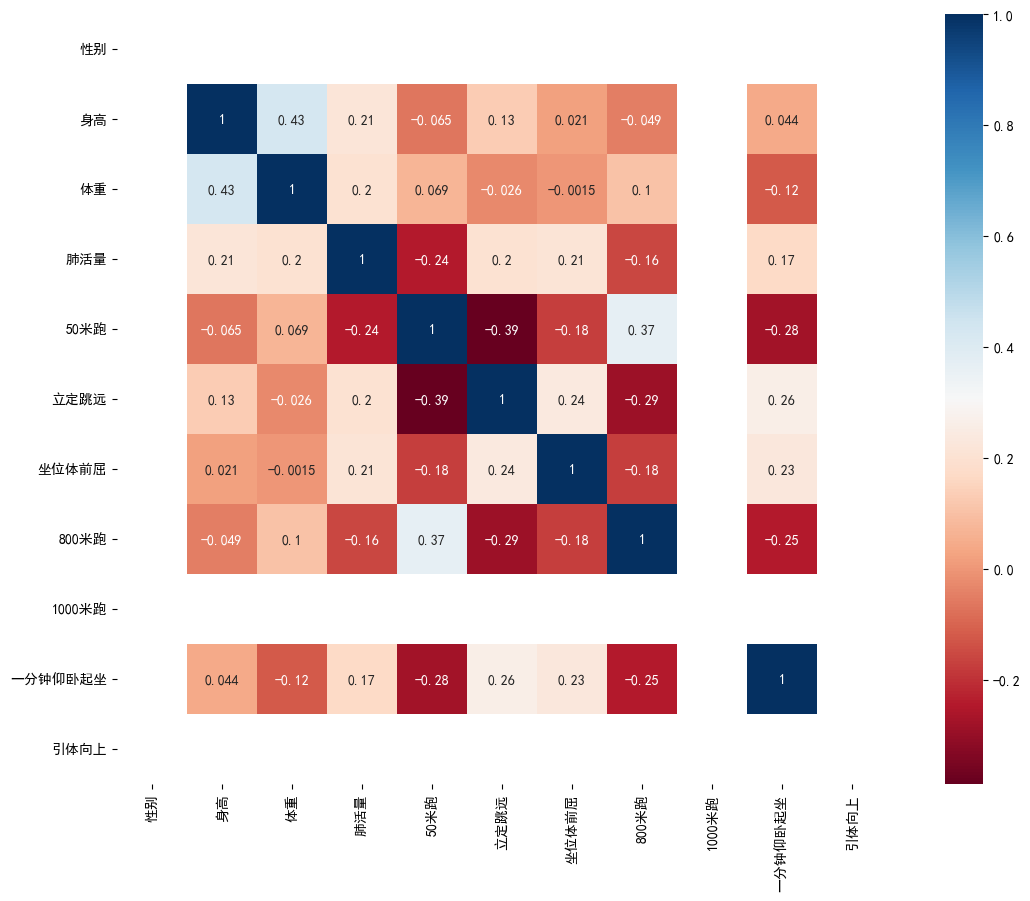

In [22]:
girl_dlcorr=girl_dl.corr()
plt.subplots(figsize=(15,10))
girl_dllabels = girl_dl.columns.values.tolist()
sns.heatmap(girl_dlcorr, annot = True, square = True, yticklabels = girl_dllabels , xticklabels = girl_dllabels , cmap='RdBu')
plt.show()

通过热力图发现，实际上体重或者身高与各个科目的体测之间，并没有太大的联系。接下来看看BMI指数与这些项目之间的相关系数。

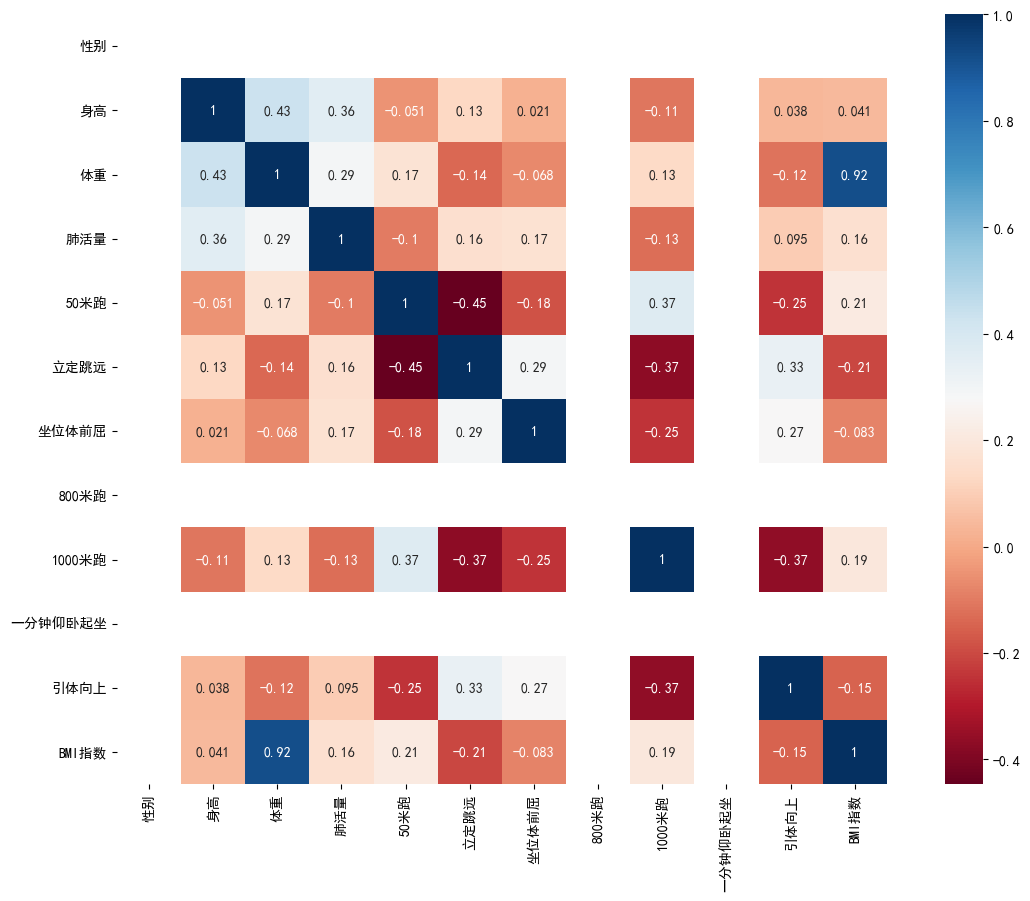

In [23]:
boy_bmi= (boy_dl["体重"]/((boy_dl["身高"]/100)**2))
boy_dl["BMI指数"] = boy_bmi
boy_dlcorr=boy_dl.corr()
plt.subplots(figsize=(15,10))
boy_dllabels = boy_dl.columns.values.tolist()
sns.heatmap(boy_dlcorr, annot = True, square = True, yticklabels = boy_dllabels , xticklabels = boy_dllabels , cmap='RdBu')
plt.show()

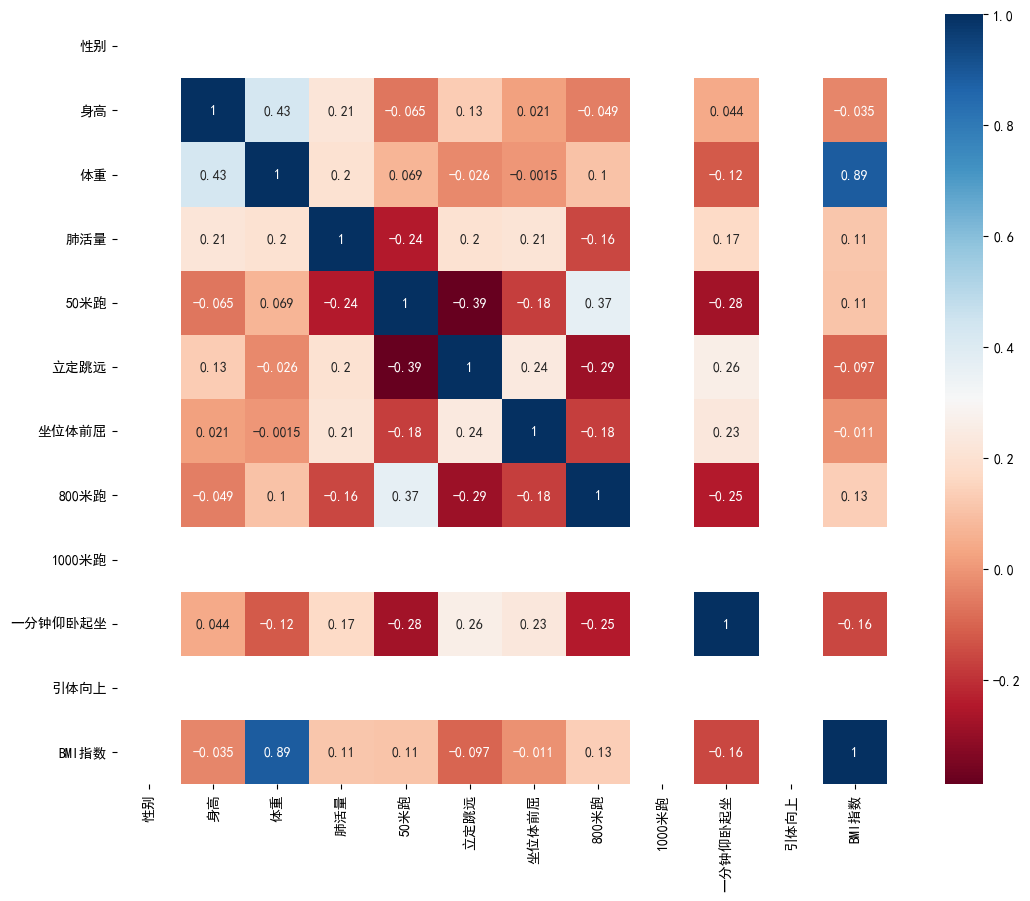

In [24]:
girl_bmi= (girl_dl["体重"]/((girl_dl["身高"]/100)**2))
girl_dl["BMI指数"] = girl_bmi
girl_dlcorr=girl_dl.corr()
plt.subplots(figsize=(15,10))
girl_dllabels = girl_dl.columns.values.tolist()
sns.heatmap(girl_dlcorr, annot = True, square = True, yticklabels = boy_dllabels , xticklabels = boy_dllabels , cmap='RdBu')
plt.show()

此时的相关性仍然不强，但是我们发现了除了肺活量这一项测试之外，其余的相关性都强了稍微一点点，但是我们并未得到有用的结论——即当相关系数小于0.2的时候不能认为它们线性相关。那么，这些数据有没有可能是非线性相关的呢？下面我们将绘画散点图观察它们之间是否真的有关系，若符合或接近某个常见的函数，我会想想如何拟合出非线性回归的图像。

从热力图中我们发现，与体重有线性相关性的只有身高与肺活量。由于体重与身高之间并未有评分的关系，那我们先看看体重与肺活量之间的散点图并归纳出它们之间的关系

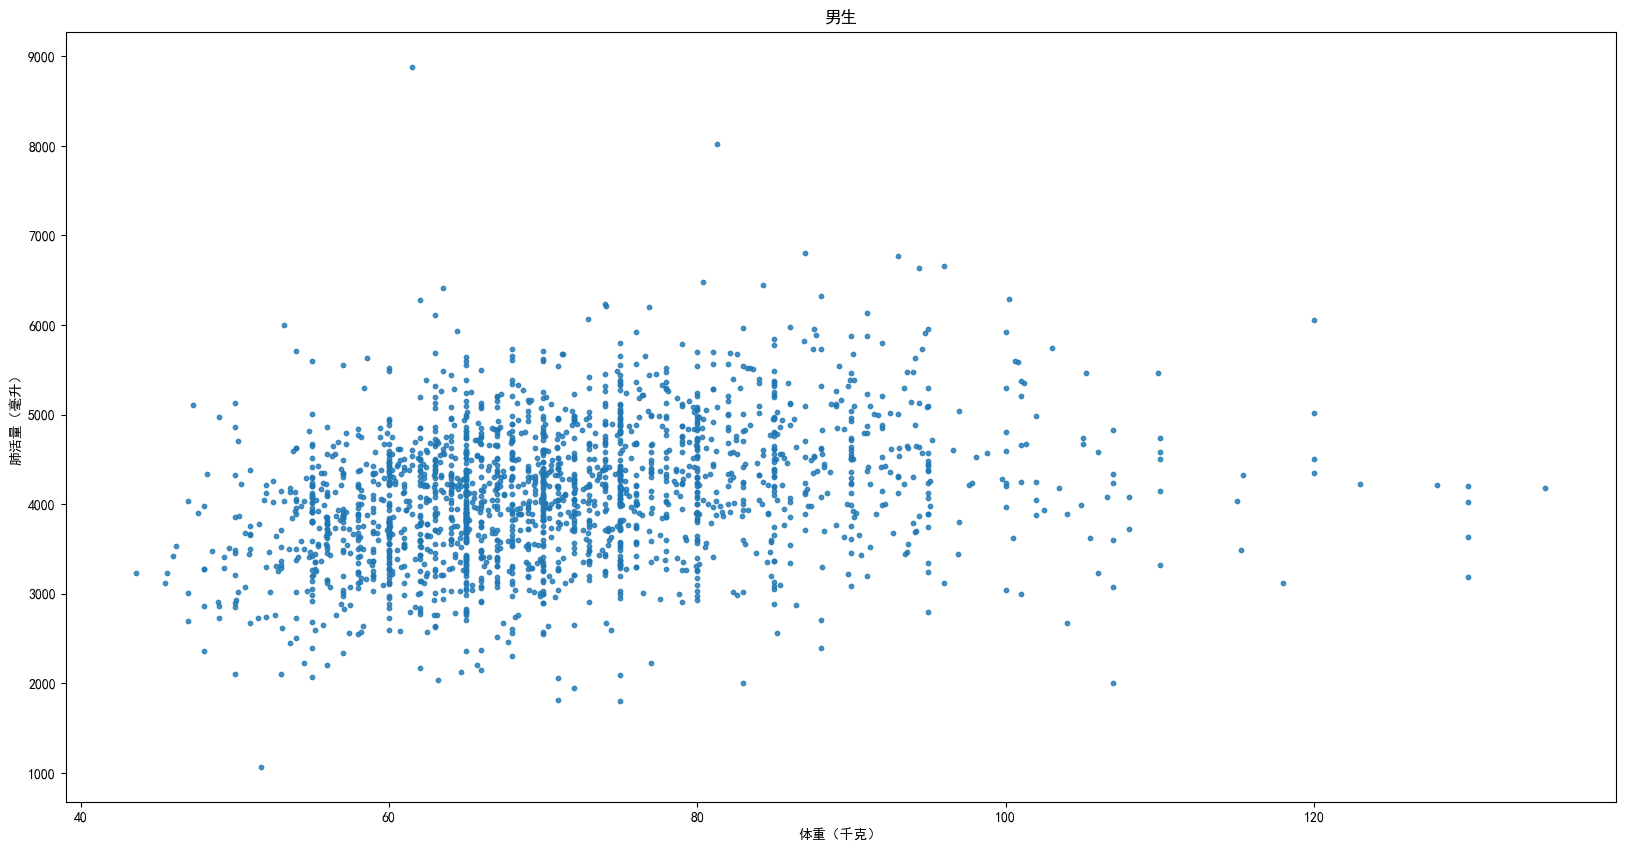

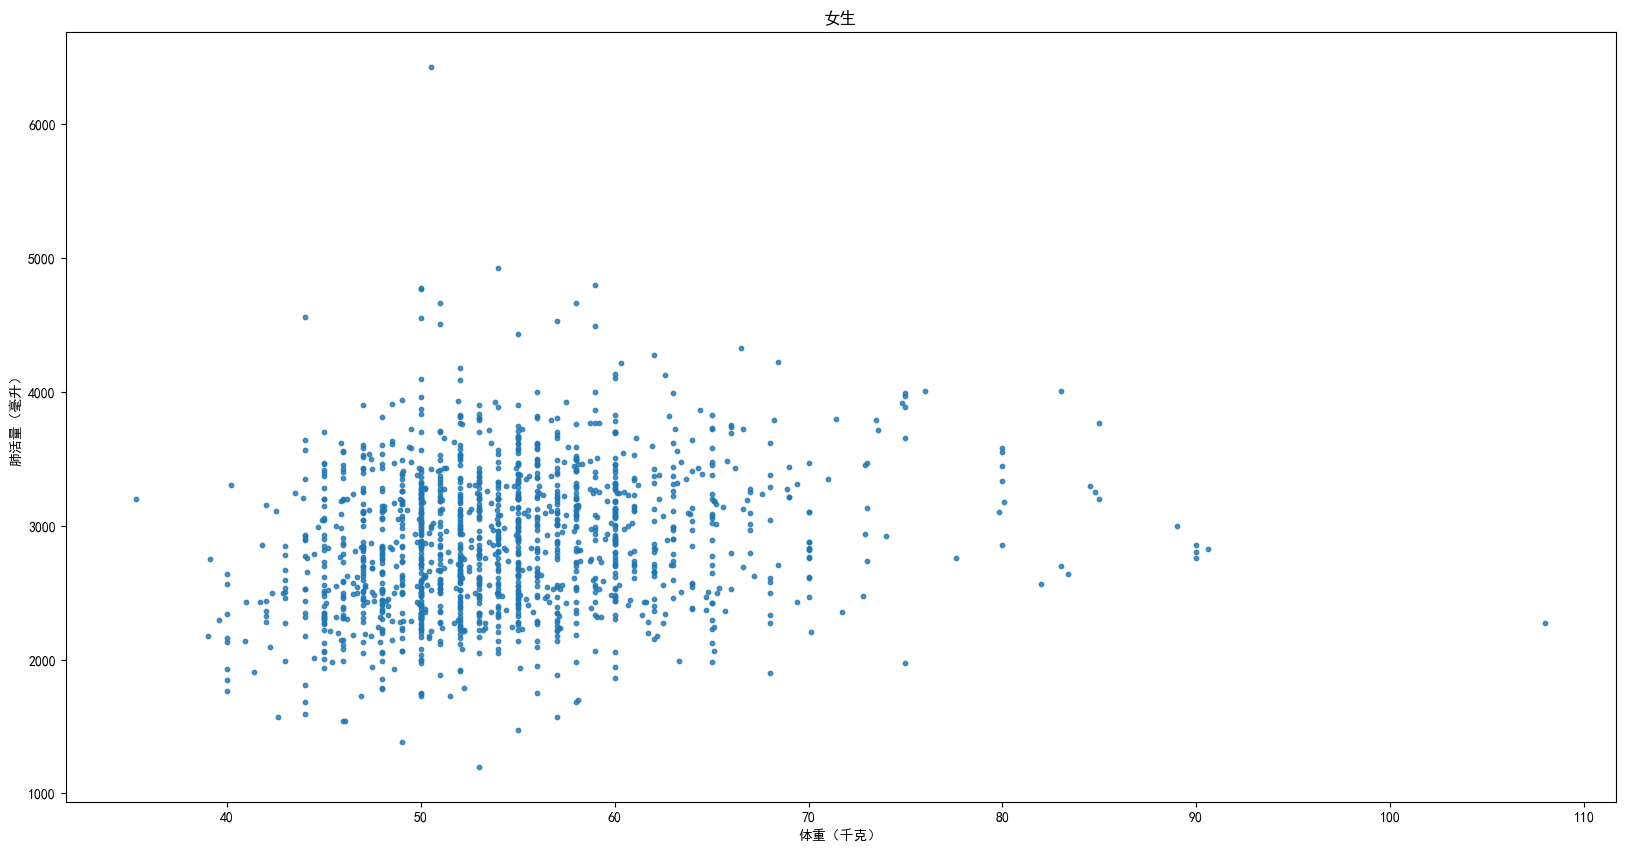

In [25]:

plt.figure(figsize = (20,10))
plt.scatter(boy_dl["体重"],boy_dl["肺活量"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("男生")
plt.ylabel("肺活量（毫升）")
plt.show()


plt.figure(figsize = (20,10))
plt.scatter(girl_dl["体重"],girl_dl["肺活量"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("女生")
plt.ylabel("肺活量（毫升）")
plt.show()

观察可知，男生的散点图相较于女生的散点图，在肺活量这个轴方向上更加密集，而女生在体重这个轴上更加密集（这应该是个普遍现象，即在后面的散点图上都应该是这种规律）。由图像看出，男女生肺活量接近于一个上凸函数。我猜测可能是对数函数，下面对肺活量的指数进行散点图的绘制

0.28823895312096276
0.200957934021615


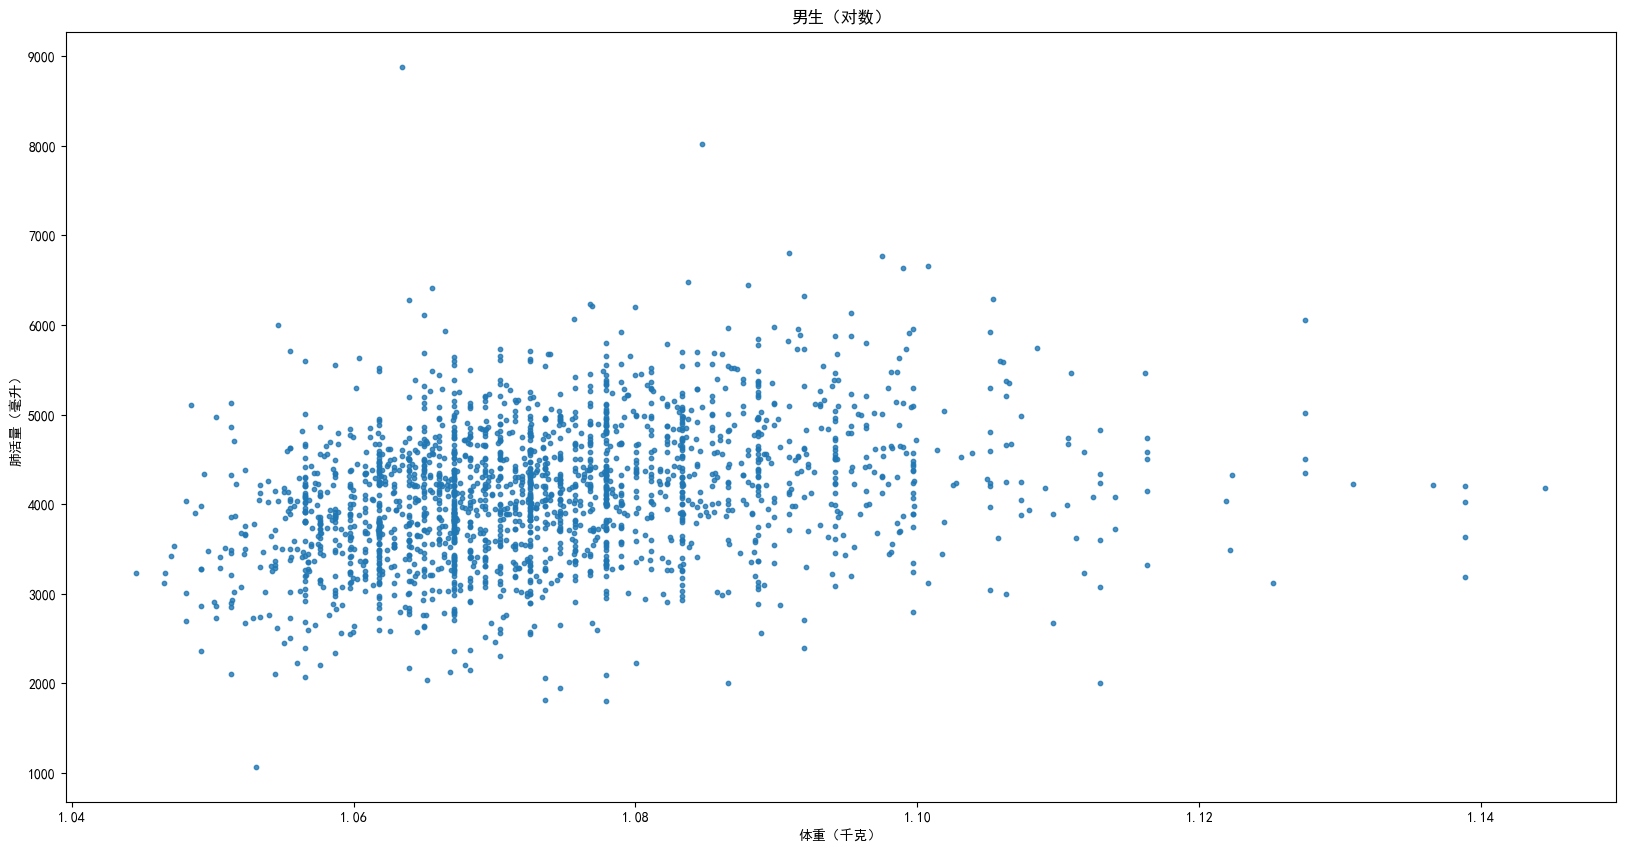

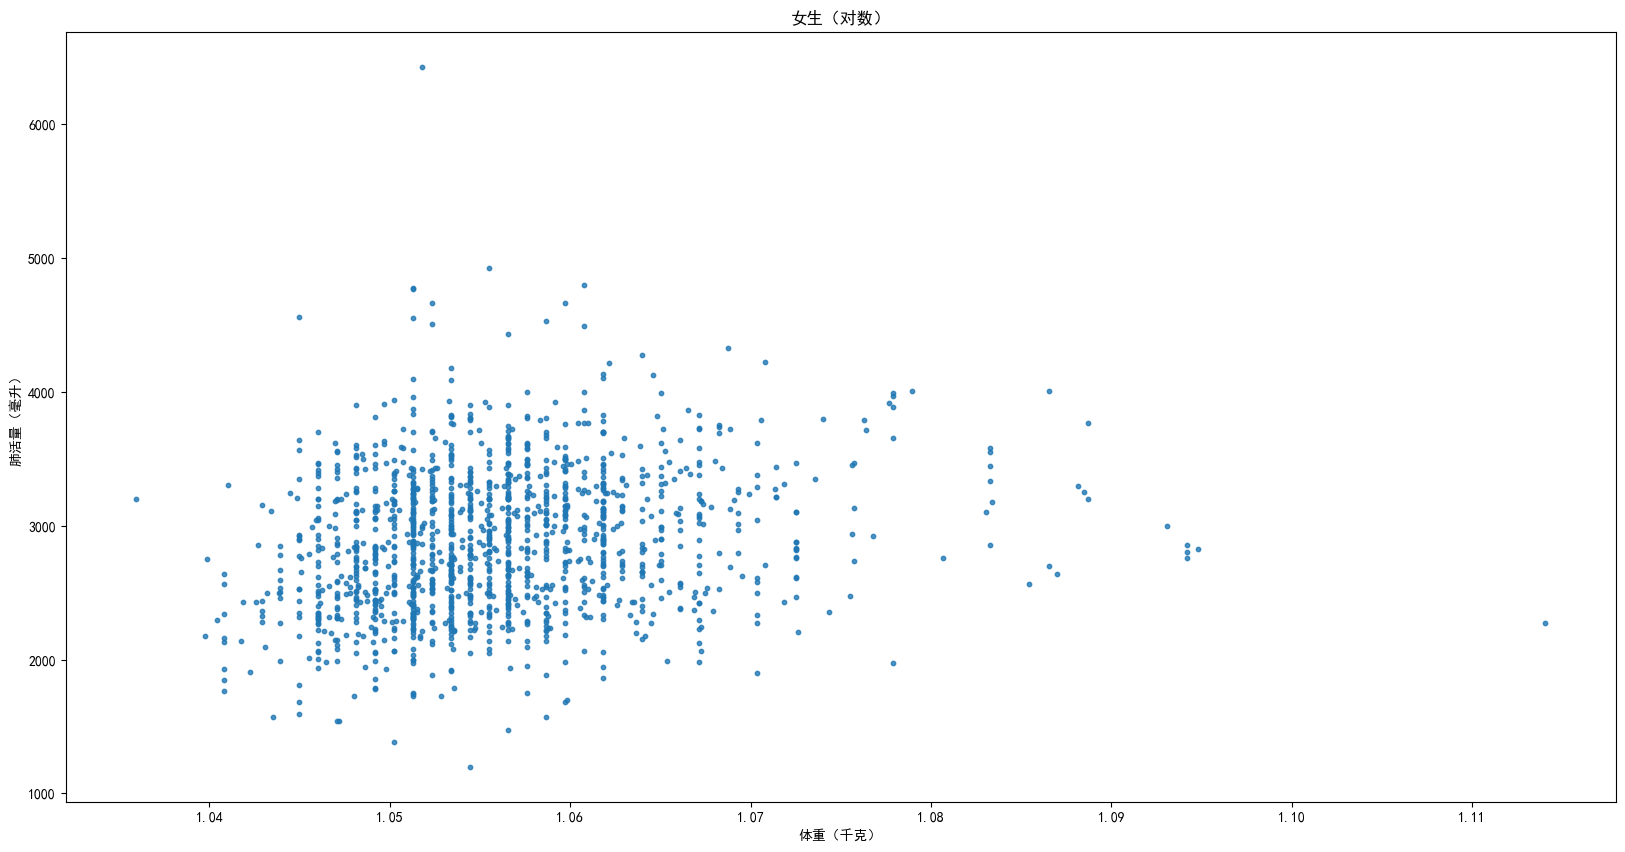

In [26]:
boy_exptz=np.exp(boy_dl["体重"]/1000)
plt.figure(figsize = (20,10))
plt.scatter(boy_exptz,boy_dl["肺活量"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("男生（对数）")
plt.ylabel("肺活量（毫升）")
corr_ln_fhl_tz=boy_exptz.corr(boy_dl["肺活量"])
print(corr_ln_fhl_tz)

girl_exptz=np.exp(girl_dl["体重"]/1000)
plt.figure(figsize = (20,10))
plt.scatter(girl_exptz,girl_dl["肺活量"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("女生（对数）")
plt.ylabel("肺活量（毫升）")
corr_ln_fhl_tz=girl_exptz.corr(girl_dl["肺活量"])
print(corr_ln_fhl_tz)
plt.show()

通过取对数数据的计算，我们发现男生组的相关关系有一定的增强而女生基本保持不变。这说明从统计概念上讲，男女生体重越大，肺活量的增长率变低，但是肺活量仍在增长。这是符合边缘效应规律的。至于体重为什么只会和肺活量有着较强的关系，是因为体重增长对成年人身体的比例改变不大，所以肺和人体等比例增大，肺越大气体交换的越多，肺活量越大。

In [92]:
print(boy_dl["肺活量"].mean())
print(girl_dl["肺活量"].mean())
print(boy_dl["肺活量"].var())
print(girl_dl["肺活量"].var())

4121.509656146962
2885.760553633218
572864.3659528978
281283.1725426296


我发现男女生平均肺活量都在76-78分的区间之内，还是较公平的。男生组的方差较大，是由于男生的肺活量波动较女生大所导致，综上我还是认为肺活量的评定还是很公平的

接下来大部分的数据与体重的线性相关性都不是非常的好，那我们还是选择最相关的几项先分析。比如说引体向上，仰卧起坐和长跑

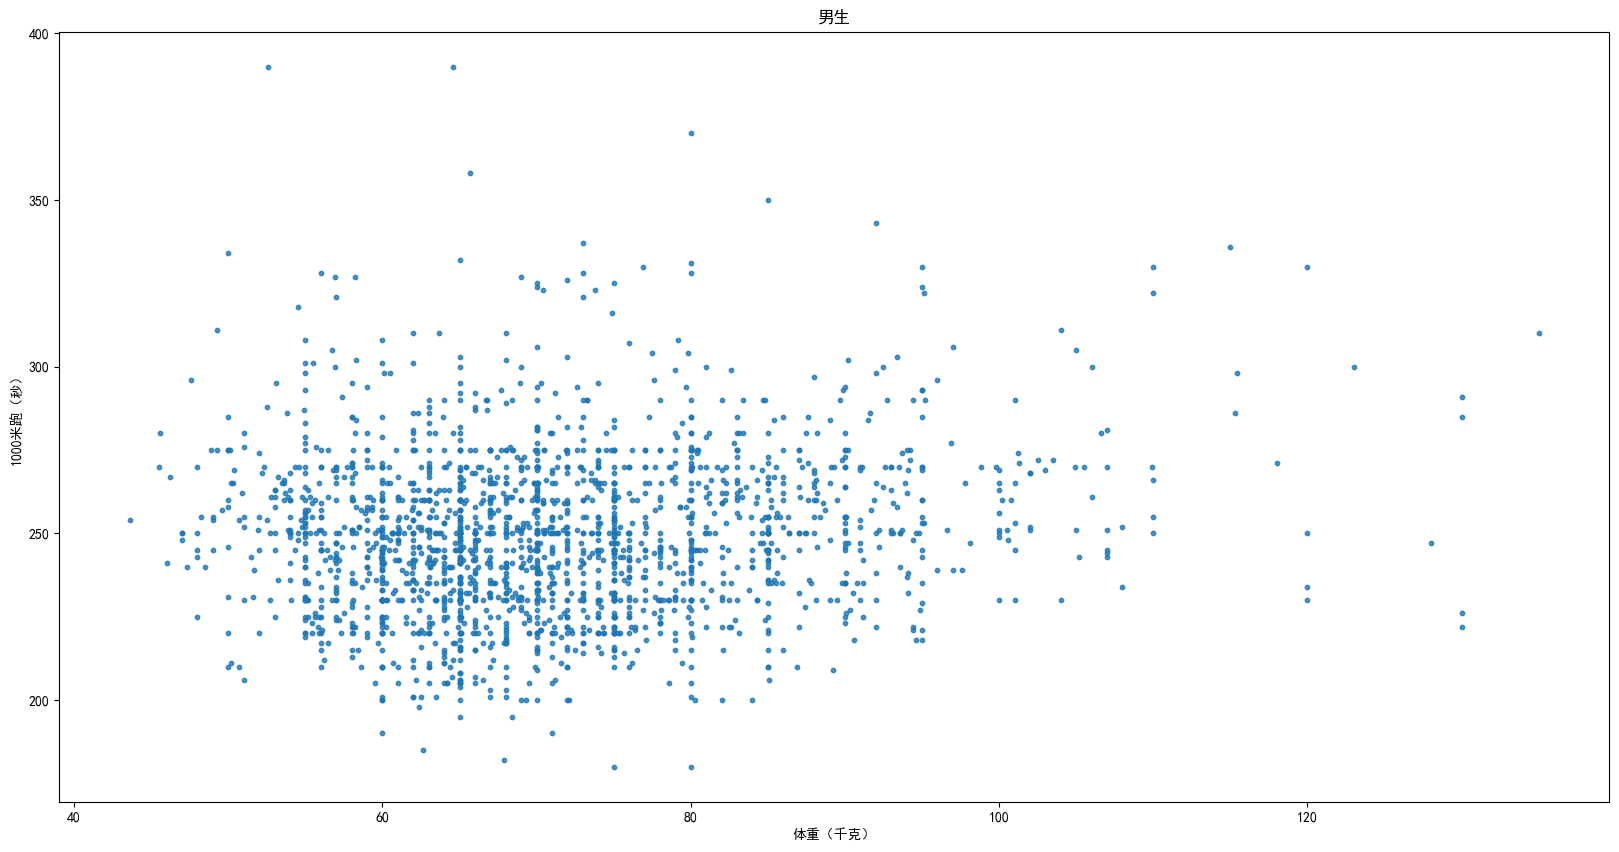

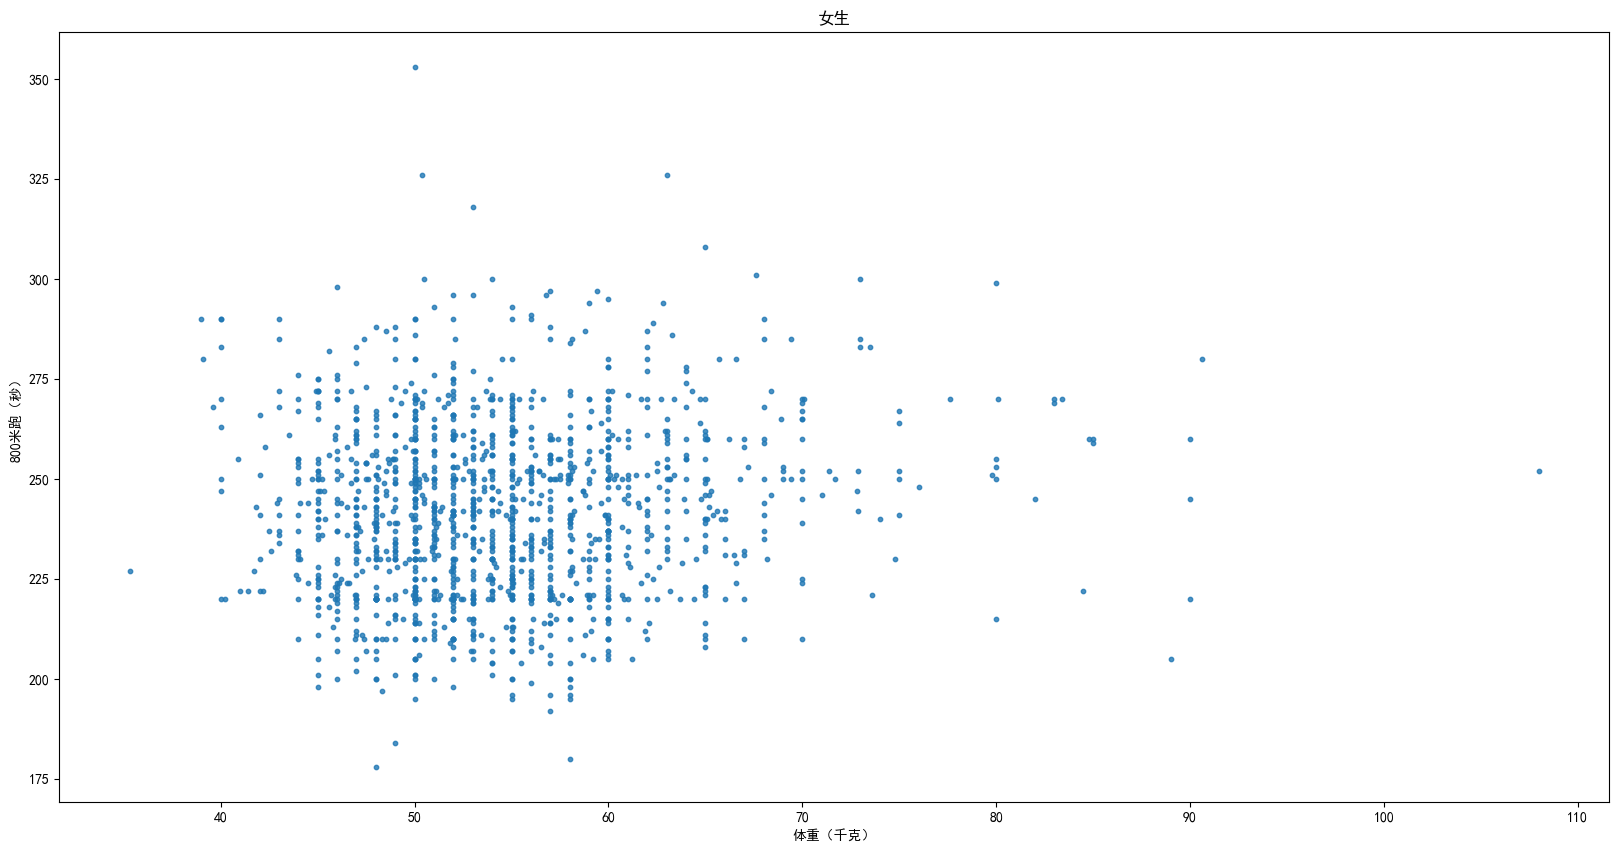

In [27]:
plt.figure(figsize = (20,10))
plt.scatter(boy_dl["体重"],boy_dl["1000米跑"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("男生")
plt.ylabel("1000米跑（秒）")
plt.show()


plt.figure(figsize = (20,10))
plt.scatter(girl_dl["体重"],girl_dl["800米跑"],alpha=0.8,s=10)
plt.xlabel("体重（千克）")
plt.title("女生")
plt.ylabel("800米跑（秒）")
plt.show()

这个散点图是相当的散，表示了体重与长跑之间基本上没有线性的关系。甚至于说，这个图显示出体重基本上与长跑成绩没有关系。不过结果出乎我的预料，长跑时间较长的同学，体重一般是比较轻的，尤其是女生，体重大的同学不一定会是长跑成绩不佳的。

此时我们发现，男生的BMI指数和1000米跑有一定的相关性，我们来分别看看男女生的BMI指数与长跑成绩的散点图

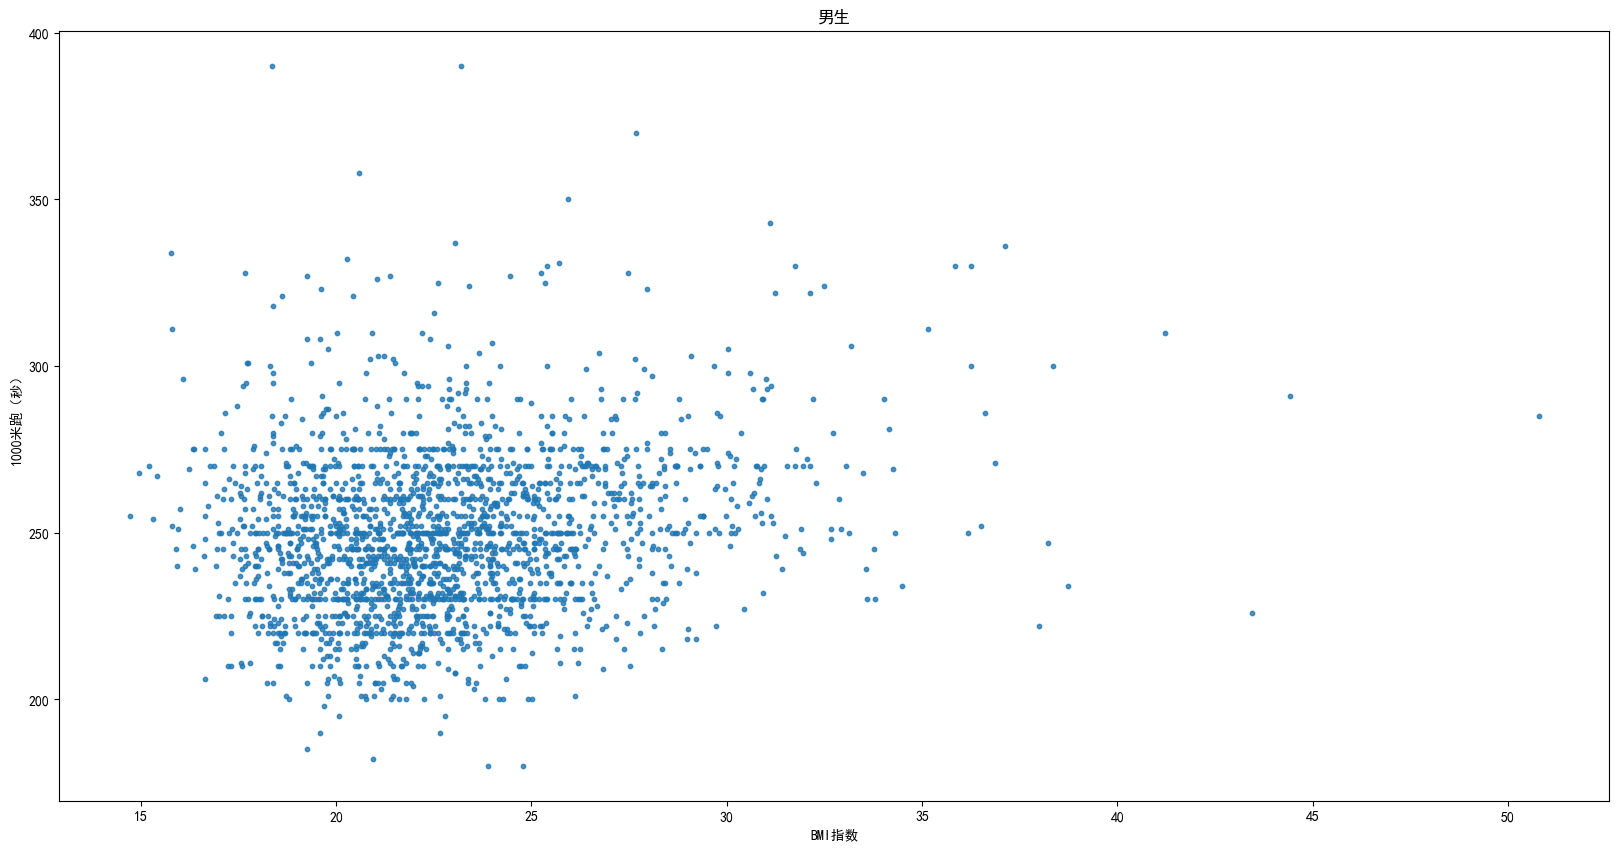

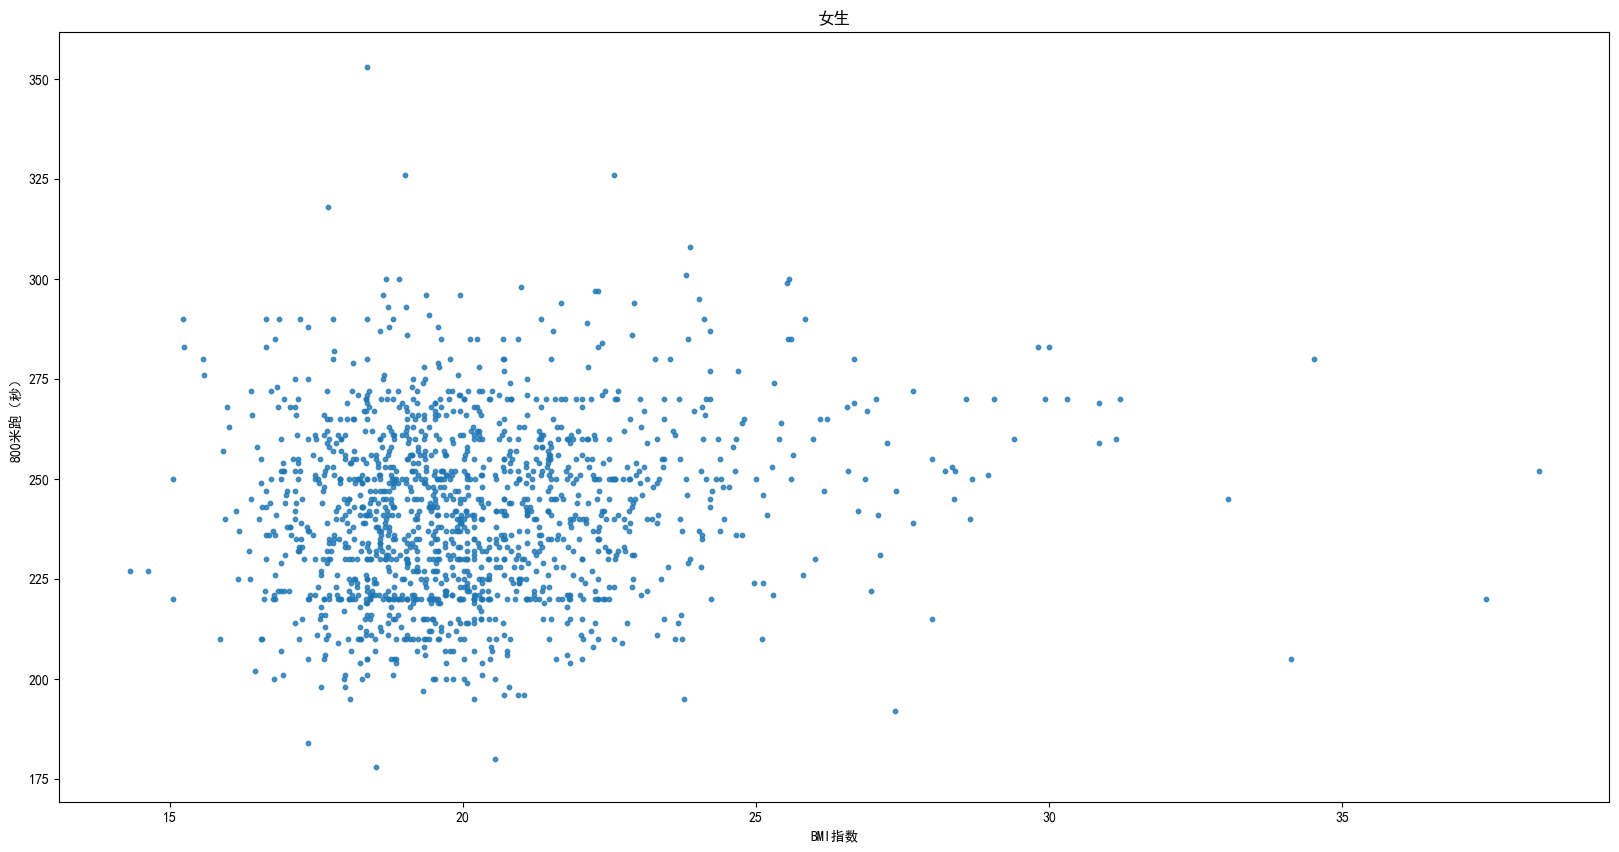

In [28]:
plt.figure(figsize = (20,10))
plt.scatter(boy_dl["BMI指数"],boy_dl["1000米跑"],alpha=0.8,s=10)
plt.xlabel("BMI指数")
plt.title("男生")
plt.ylabel("1000米跑（秒）")
plt.show()


plt.figure(figsize = (20,10))
plt.scatter(girl_dl["BMI指数"],girl_dl["800米跑"],alpha=0.8,s=10)
plt.xlabel("BMI指数")
plt.title("女生")
plt.ylabel("800米跑（秒）")
plt.show()

虽然此时的成绩与BMI指数的相关系数仍然不是非常的大，但是我们可以稍微看得出，BMI较大的同学较相对小的同学，长跑时间有一定的延长，我们分析一下数据并画折线图看看它们之间的差距,这里男生分为六组，女生分为五组。

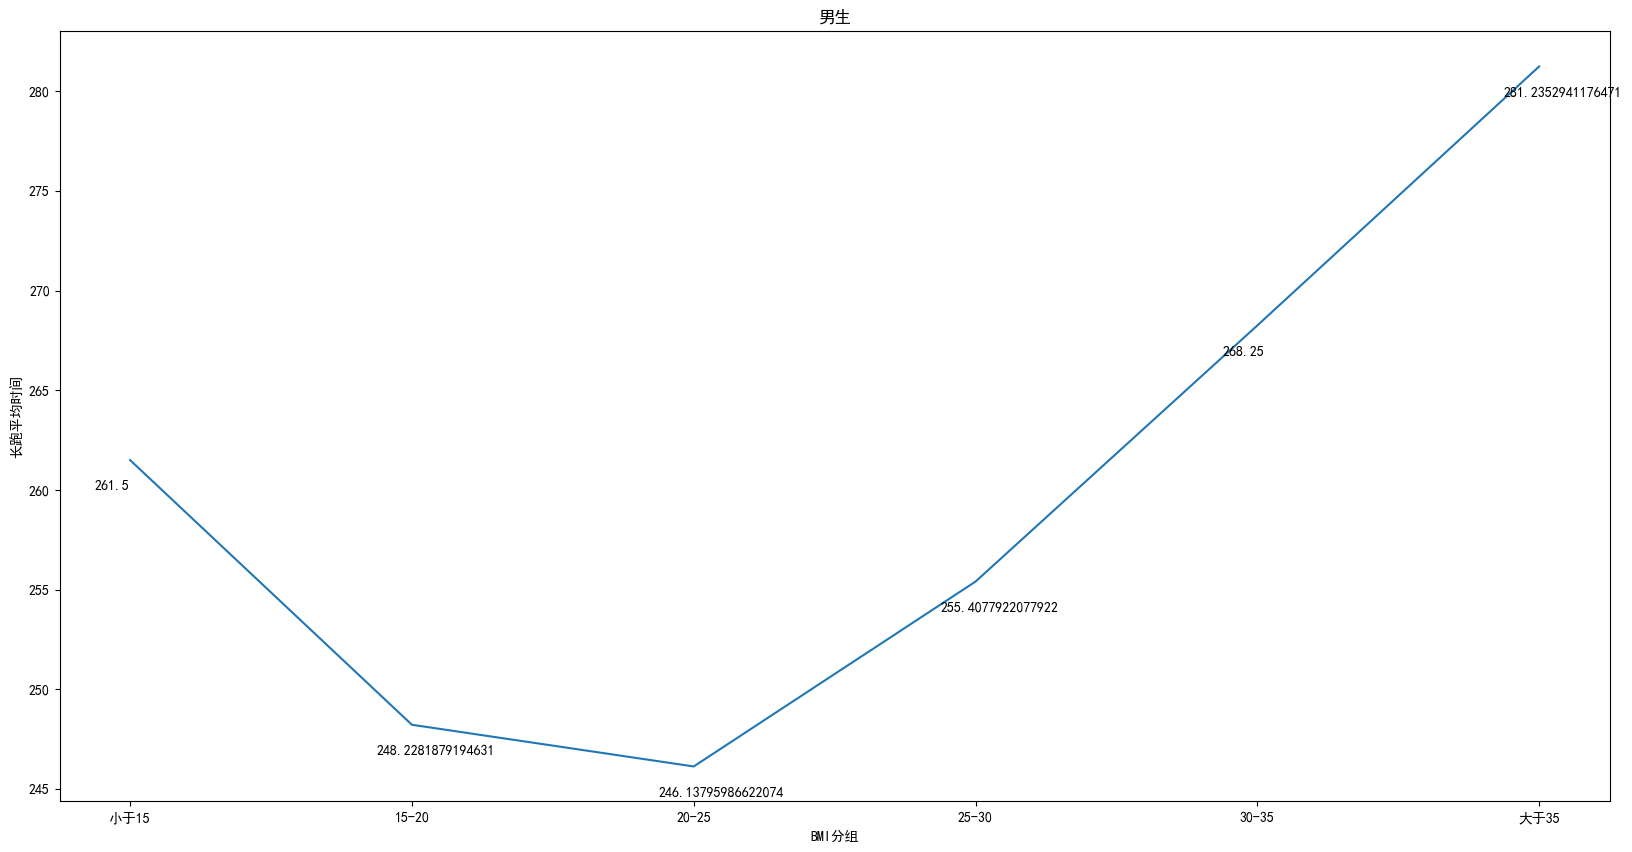

In [60]:
boy_bmigroup=[0,0,0,0,0,0]
avg_bmi_1km = [0,0,0,0,0,0]
boy_bmi = np.float64(boy_dl["BMI指数"])
boy_bmi_1km= np.array([boy_dl["BMI指数"],boy_dl["1000米跑"]])
for i in range (len(boy_dl["BMI指数"])):
    if boy_bmi[i] <= 15 :
        boy_bmigroup[0]+=1
        avg_bmi_1km[0] += boy_bmi_1km[1][i]
        continue
    elif boy_bmi[i] > 15 and boy_bmi[i] <= 20:
        boy_bmigroup[1]+=1
        avg_bmi_1km[1] += boy_bmi_1km[1][i]
        continue
    elif boy_bmi[i] > 20 and boy_bmi[i] <= 25:
        boy_bmigroup[2]+=1
        avg_bmi_1km[2] += boy_bmi_1km[1][i]
        continue
    elif boy_bmi[i] > 25 and boy_bmi[i] <= 30:
        boy_bmigroup[3]+=1
        avg_bmi_1km[3] += boy_bmi_1km[1][i]
        continue
    elif boy_bmi[i] > 30 and boy_bmi[i] <= 35:
        boy_bmigroup[4]+=1
        avg_bmi_1km[4] += boy_bmi_1km[1][i]
        continue
    elif boy_bmi[i] > 35:
        boy_bmigroup[5]+=1
        avg_bmi_1km[5] += boy_bmi_1km[1][i]
        continue
avg_bmi_1km = np.float64(avg_bmi_1km)
boy_bmigroup = np.float64(boy_bmigroup)
avg_bmi_1km = avg_bmi_1km/boy_bmigroup

plt.figure(figsize = (20,10))
boy_bmigrouplist=["小于15","15-20","20-25","25-30","30-35","大于35"]
plt.xlabel("BMI分组")
plt.title("男生")
plt.ylabel("长跑平均时间")
for i in range (6):
    plt.text(x=i-0.125 ,y=avg_bmi_1km[i]-1.5 ,s=avg_bmi_1km[i])
plt.plot(boy_bmigrouplist,avg_bmi_1km)
plt.show()

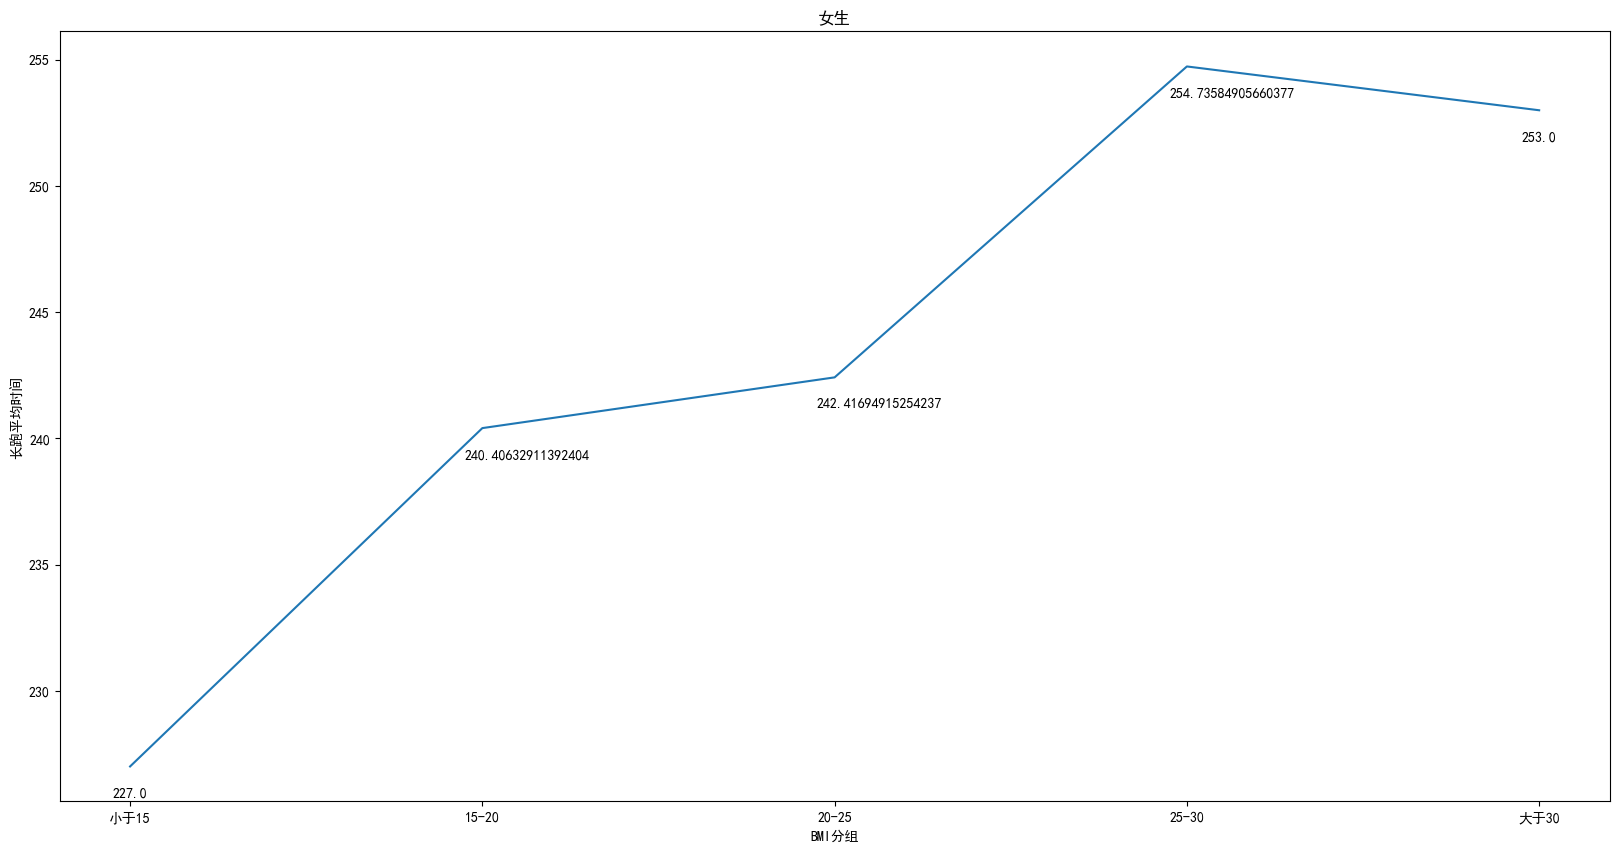

In [68]:
girl_bmigroup=[0,0,0,0,0]
avg_bmi_800m = [0,0,0,0,0]
girl_bmi = np.float64(girl_dl["BMI指数"])
girl_bmi_800m= np.array([girl_dl["BMI指数"],girl_dl["800米跑"]])
for i in range (len(girl_dl["BMI指数"])):
    if girl_bmi[i] <= 15 :
        girl_bmigroup[0]+=1
        avg_bmi_800m[0] += girl_bmi_800m[1][i]
        continue
    elif girl_bmi[i] > 15 and girl_bmi[i] <= 20:
        girl_bmigroup[1]+=1
        avg_bmi_800m[1] += girl_bmi_800m[1][i]
        continue
    elif     girl_bmi[i] > 20 and girl_bmi[i] <= 25:
        girl_bmigroup[2]+=1
        avg_bmi_800m[2] += girl_bmi_800m[1][i]
        continue
    elif girl_bmi[i] > 25 and girl_bmi[i] <= 30:
        girl_bmigroup[3]+=1
        avg_bmi_800m[3] += girl_bmi_800m[1][i]
        continue
    elif    girl_bmi[i] >= 30:
        girl_bmigroup[4]+=1
        avg_bmi_800m[4] += girl_bmi_800m[1][i]
        continue
        
avg_bmi_800m = np.float64(avg_bmi_800m)
girl_bmigroup = np.float64(girl_bmigroup)
avg_bmi_800m = avg_bmi_800m/girl_bmigroup

plt.figure(figsize = (20,10))
girl_bmigrouplist=["小于15","15-20","20-25","25-30","大于30"]
plt.xlabel("BMI分组")
plt.title("女生")
plt.ylabel("长跑平均时间")
for i in range (5):
    plt.text(x=i-0.05 ,y=avg_bmi_800m[i]-1.2 ,s=avg_bmi_800m[i])
plt.plot(girl_bmigrouplist,avg_bmi_800m)
plt.show()

In [91]:
print(boy_dl["1000米跑"].mean())
print(girl_dl["800米跑"].mean())

249.34620819594912
241.82145328719724


结论还是比较明显的,虽然BMI指数与长跑之间并没有什么线性的关系，但是分组的折线图却表现出来了BMI指数较大的一组，长跑的平均时间也较长，这也代表着超重的身材跑的更慢。而男生组还体现出了BMI指数较低的部分同学也没有体格适中的同学机敏，同时这部分体格适中的同学也是BMI指数得分较高的同学。在男生组我还是认为BMI指数还是有一定能力反应同学们的长跑水平的<br>
但是从性别的对比来看，似乎每一个bmi组的长跑成绩，平均成绩男生都比女生较慢一点点，但是从评分角度来看，女生各组的均分(78-80,72-74,70-72,66-68,66-68)要都要比男生(62-64,68-70,68-70,64-66,60-62,50-60)高一点,而且整体的均分(72-74,68-70)也体现出了女生在长跑这方面更有优势一点,我认为此处的男女生差距村咋，应该在评分上略作细调

另外两个略微有一点点相关性的就是仰卧起坐和引体向上，接下来画出这两个项目有关体重与BMI指数的散点图

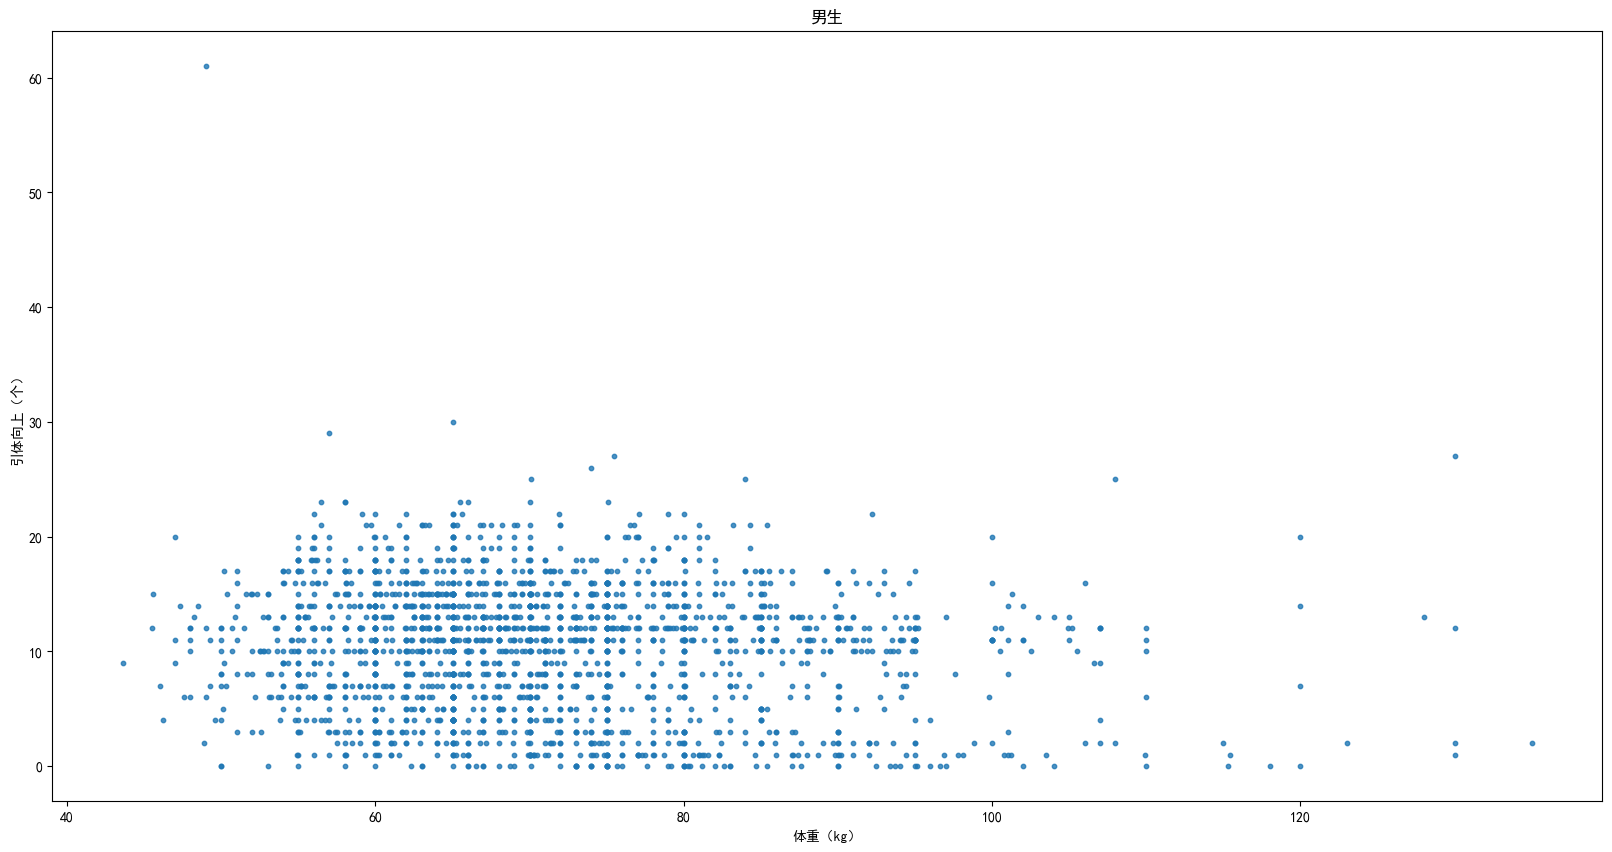

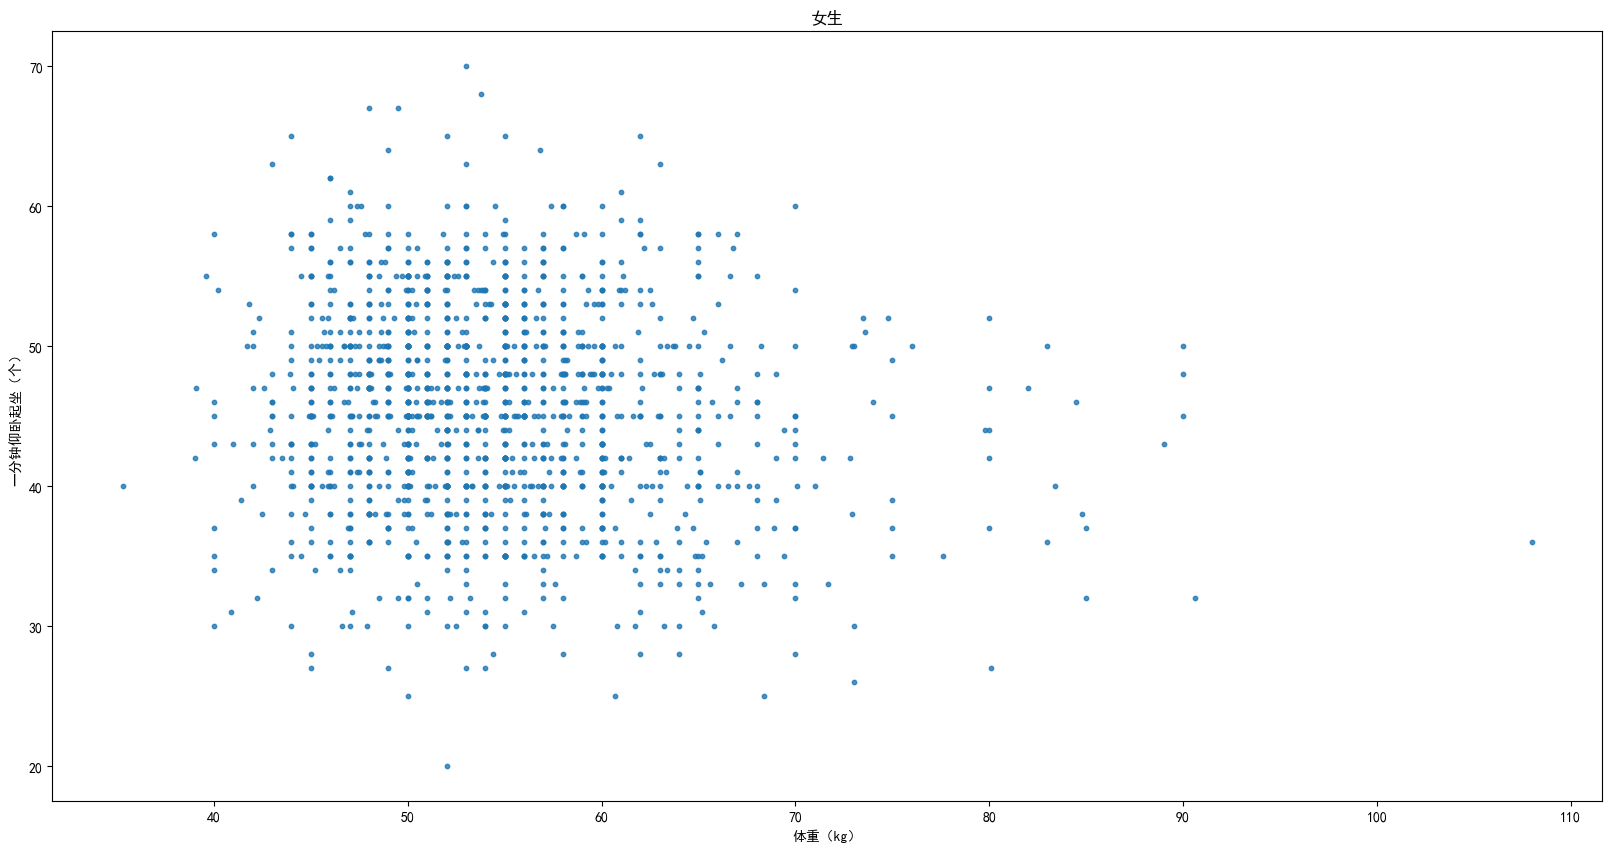

In [31]:
plt.figure(figsize = (20,10))
plt.scatter(boy_dl["体重"],boy_dl["引体向上"],alpha=0.8,s=10)
plt.xlabel("体重（kg）")
plt.title("男生")
plt.ylabel("引体向上（个）")
plt.show()


plt.figure(figsize = (20,10))
plt.scatter(girl_dl["体重"],girl_dl["一分钟仰卧起坐"],alpha=0.8,s=10)
plt.xlabel("体重（kg）")
plt.title("女生")
plt.ylabel("一分钟仰卧起坐（个）")
plt.show()

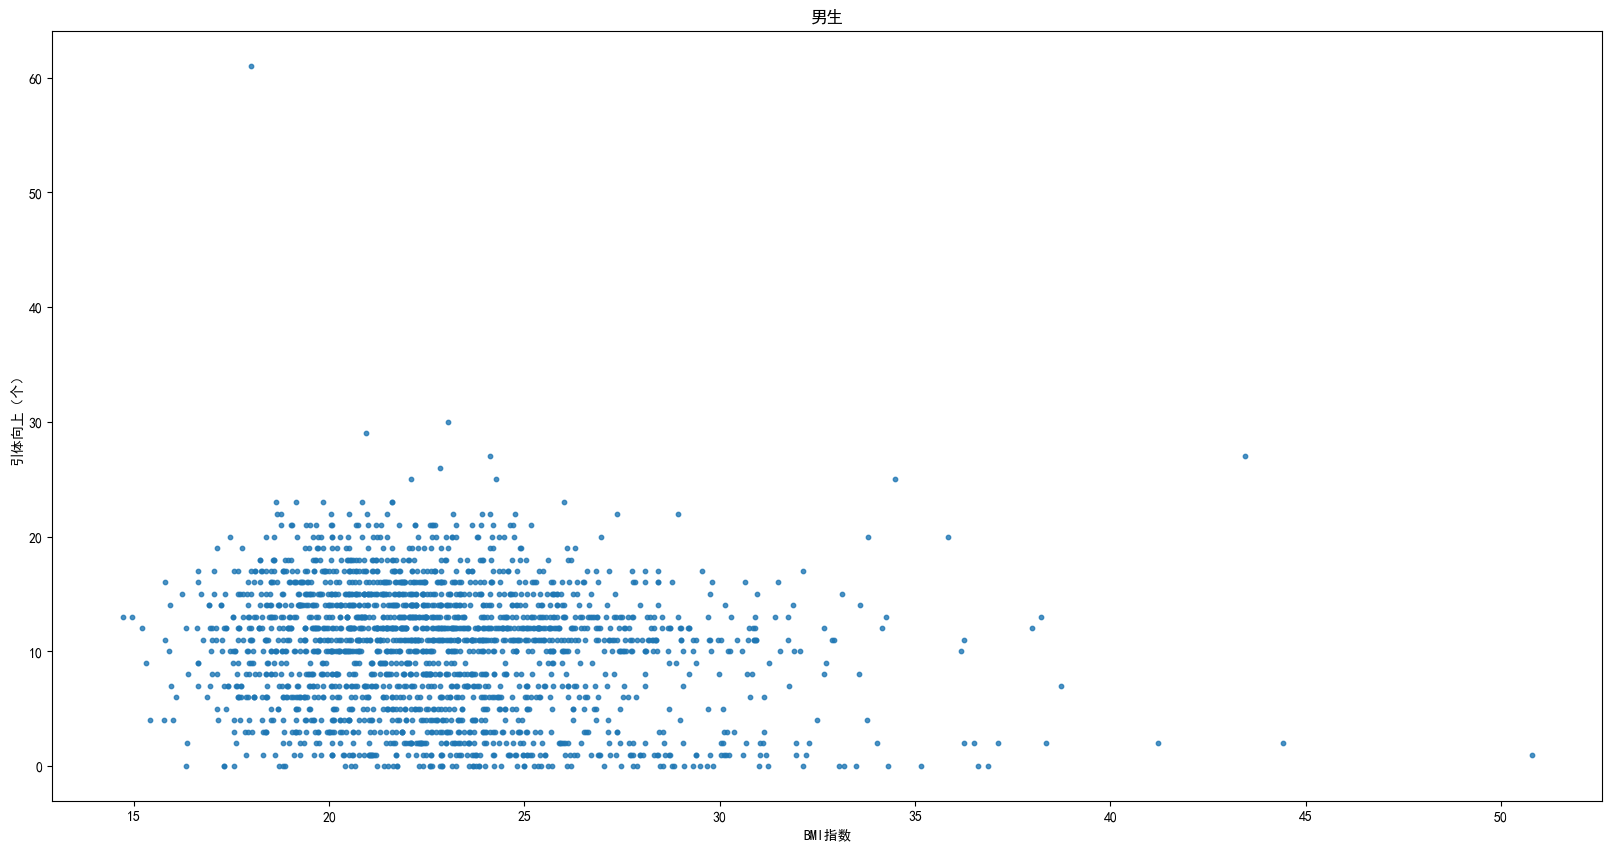

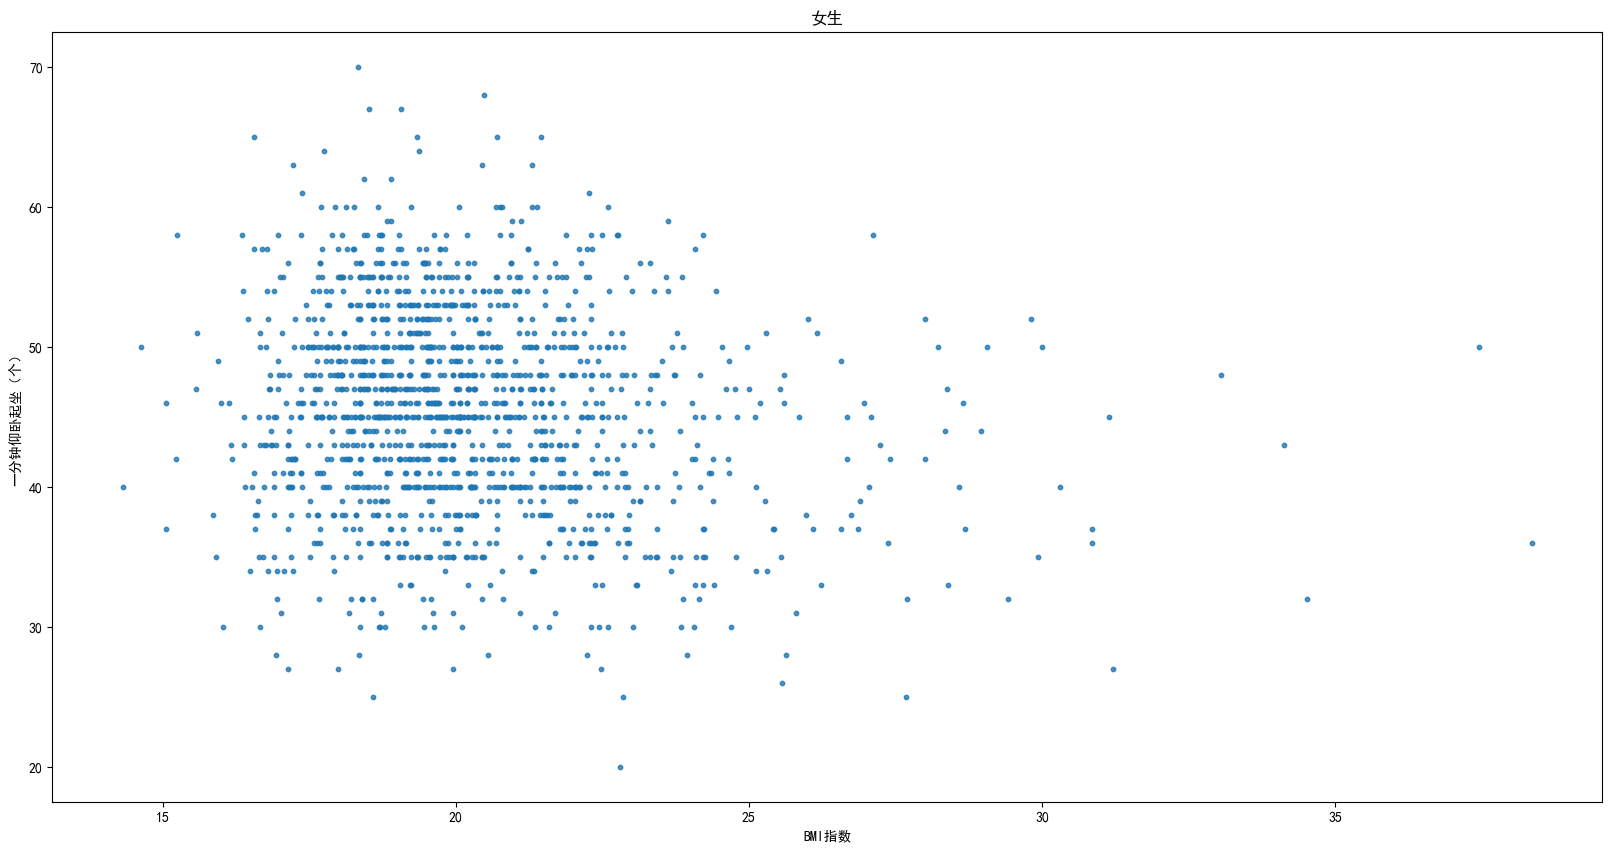

In [32]:
plt.figure(figsize = (20,10))
plt.scatter(boy_dl["BMI指数"],boy_dl["引体向上"],alpha=0.8,s=10)
plt.xlabel("BMI指数")
plt.title("男生")
plt.ylabel("引体向上（个）")
plt.show()


plt.figure(figsize = (20,10))
plt.scatter(girl_dl["BMI指数"],girl_dl["一分钟仰卧起坐"],alpha=0.8,s=10)
plt.xlabel("BMI指数")
plt.title("女生")
plt.ylabel("一分钟仰卧起坐（个）")
plt.show()

实际上确实没有线性的关系，但是BMI指数的散点图比体重的要密集一点点，我们不妨也看看分组折线图的表现是什么样的

[13.         10.95302013 10.53929766  9.34285714  7.63157895  6.64705882]


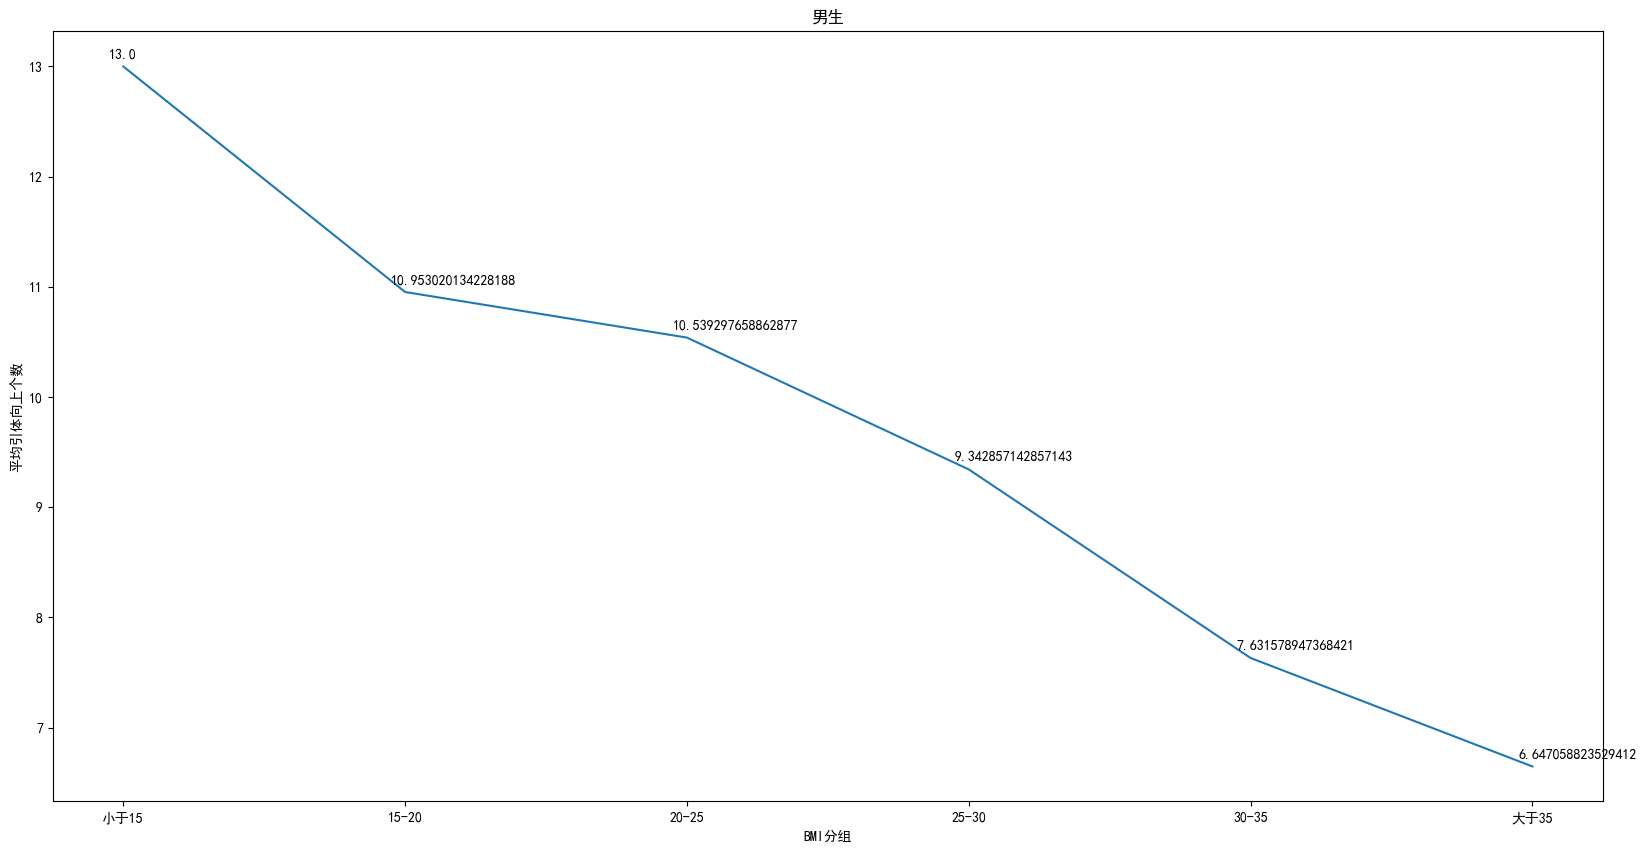

In [79]:
avg_bmi_ytxs = [0,0,0,0,0,0]
boy_bmi_ytxs= np.array([boy_dl["BMI指数"],boy_dl["引体向上"]])
for i in range (len(boy_dl["BMI指数"])):
    if boy_bmi[i] <= 15 :
        avg_bmi_ytxs[0] += boy_bmi_ytxs[1][i]
        continue
    elif boy_bmi[i] > 15 and boy_bmi[i] <= 20:
        avg_bmi_ytxs[1] += boy_bmi_ytxs[1][i]
        continue
    elif boy_bmi[i] > 20 and boy_bmi[i] <= 25:
        avg_bmi_ytxs[2] += boy_bmi_ytxs[1][i]
        continue
    elif boy_bmi[i] > 25 and boy_bmi[i] <= 30:
        avg_bmi_ytxs[3] += boy_bmi_ytxs[1][i]
        continue
    elif boy_bmi[i] > 30 and boy_bmi[i] <= 35:
        avg_bmi_ytxs[4] += boy_bmi_ytxs[1][i]
        continue
    elif boy_bmi[i] > 35:
        avg_bmi_ytxs[5] += boy_bmi_ytxs[1][i]
        continue
avg_bmi_ytxs = np.float64(avg_bmi_ytxs)
avg_bmi_ytxs = avg_bmi_ytxs/boy_bmigroup

print(avg_bmi_ytxs)

plt.figure(figsize = (20,10))
boy_bmigrouplist=["小于15","15-20","20-25","25-30","30-35","大于35"]
plt.xlabel("BMI分组")
plt.title("男生")
plt.ylabel("平均引体向上个数")
for i in range (6):
    plt.text(x=i-0.05 ,y=avg_bmi_ytxs[i]+0.075 ,s=avg_bmi_ytxs[i])
plt.plot(boy_bmigrouplist,avg_bmi_ytxs)
plt.show()

[45.         46.23164557 44.89491525 41.28301887 39.4       ]


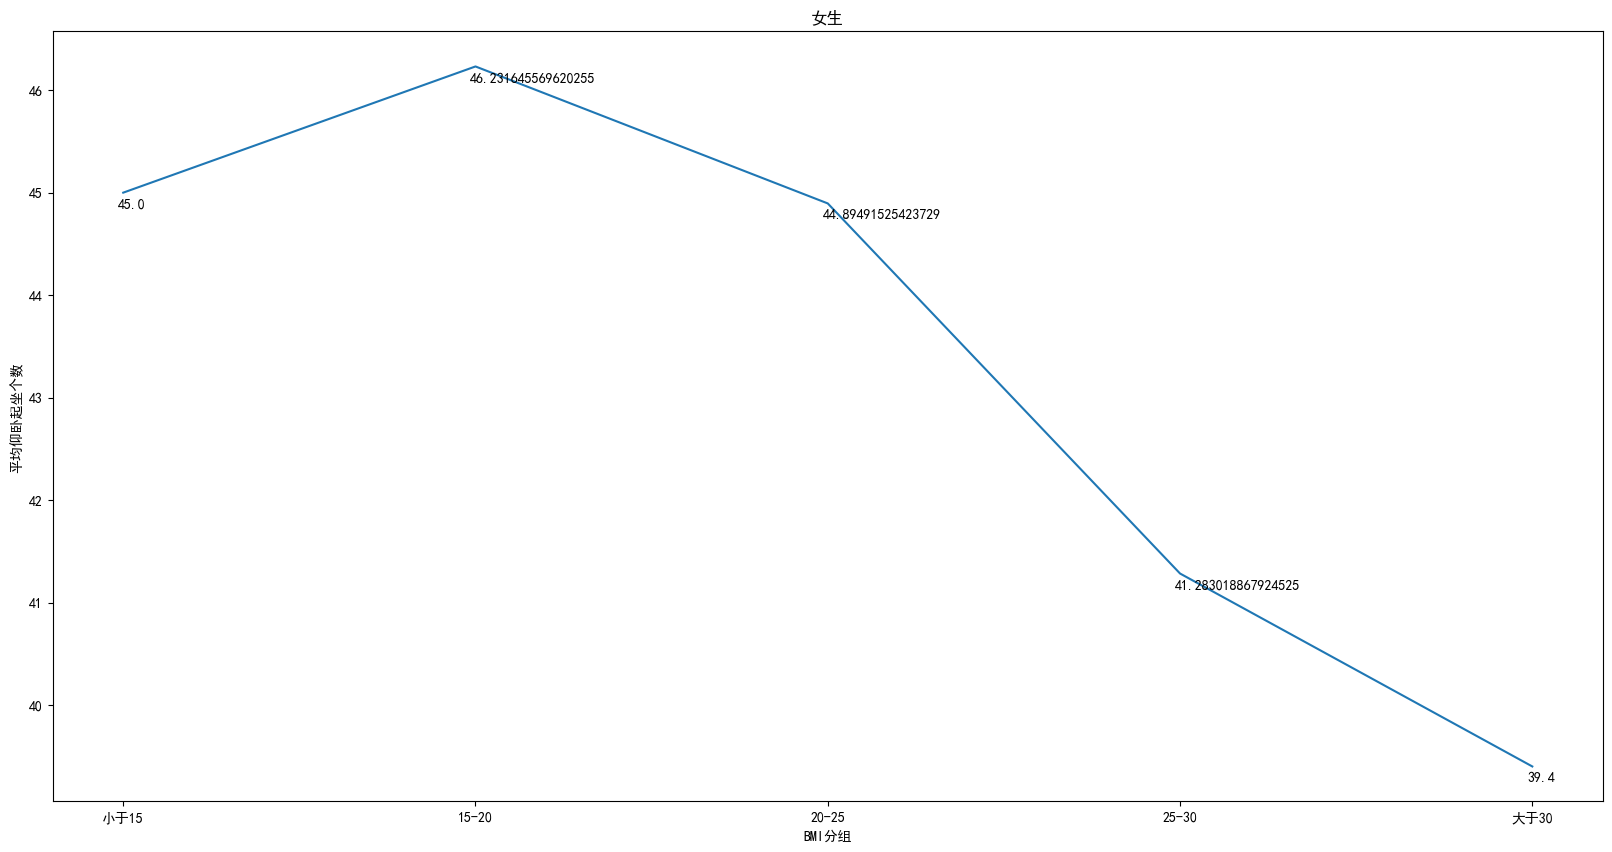

In [87]:
avg_bmi_ywqz = [0,0,0,0,0]
girl_bmi_ywqz= np.array([girl_dl["BMI指数"],girl_dl["一分钟仰卧起坐"]])
for i in range (len(girl_dl["BMI指数"])):
    if girl_bmi[i] <= 15 :
        avg_bmi_ywqz[0] += girl_bmi_ywqz[1][i]
        continue
    elif girl_bmi[i] > 15 and girl_bmi[i] <= 20:
        avg_bmi_ywqz[1] += girl_bmi_ywqz[1][i]
        continue
    elif girl_bmi[i] > 20 and girl_bmi[i] <= 25:
        avg_bmi_ywqz[2] += girl_bmi_ywqz[1][i]
        continue
    elif girl_bmi[i] > 25 and girl_bmi[i] <= 30:
        avg_bmi_ywqz[3] += girl_bmi_ywqz[1][i]
        continue
    elif girl_bmi[i] > 30:
        avg_bmi_ywqz[4] += girl_bmi_ywqz[1][i]
        continue
avg_bmi_ywqz = np.float64(avg_bmi_ywqz)
avg_bmi_ywqz = avg_bmi_ywqz/girl_bmigroup

print(avg_bmi_ywqz)

plt.figure(figsize = (20,10))
boy_bmigrouplist=["小于15","15-20","20-25","25-30","大于30"]
plt.xlabel("BMI分组")
plt.title("女生")
plt.ylabel("平均仰卧起坐个数")
for i in range (5):
    plt.text(x=i-0.015 ,y=avg_bmi_ywqz[i]-0.15 ,s=avg_bmi_ywqz[i])
plt.plot(girl_bmigrouplist,avg_bmi_ywqz)
plt.show()

折线图也仍然证明了我们的猜想，BMI最大的组的平均成绩最低，同时女生组的平均成绩最高的组落在15-20这个区间。但是总体上，BMI越大引体向上或者仰卧起坐的成绩越差，BMI较低或者中等的学生表现的会稍微的好一点。和BMI得分相近，所以我认为在男女生内横向比较成绩还是能够客观的反映出身体素质的差异的。但是性别不同导致多分的差异过大了，整体来说这两个同参考价值的项目评分还是不太妥当。

下面的几个图是完全没有线性关系的散点图了，包括体前屈，短跑以及立定跳远。我们可以预测它们与体重，bmi关系不大。但是如果说bmi分组与其变化趋势，这还是有一定的探索空间的。